In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.executable

'C:\\tools\\Anaconda3\\python.exe'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ot
import tqdm
import sklearn.decomposition
import sklearn.cluster
import itertools
import time
import umap

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [4]:
from src.utils import *
from src.encoders_decoders import *
from src.dwe import *
from src.data_mining import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Tests

In [6]:
e = Encoder(20, 2, [10, 5])

In [7]:
d = Decoder(2, 20, [5, 10])

In [8]:
A = torch.tensor(np.random.rand(5, 20), dtype=torch.float32)

In [9]:
e(A)

tensor([[-0.3603,  0.3536],
        [-0.3007,  0.3419],
        [-0.3325,  0.3669],
        [-0.3097,  0.3559],
        [-0.2692,  0.3034]], grad_fn=<AddmmBackward>)

In [10]:
d(e(A))[0]

tensor([0.5290, 0.4902, 0.4600, 0.5172, 0.4190, 0.4894, 0.5510, 0.5179, 0.4976,
        0.5067, 0.5271, 0.5084, 0.5263, 0.5005, 0.4474, 0.5027, 0.4596, 0.5384,
        0.5614, 0.5561], grad_fn=<SelectBackward>)

In [11]:
kl_loss = torch.nn.KLDivLoss(reduction='mean')

In [12]:
a = torch.ones(6, 20) / 20
b = torch.ones(6, 20) / 20 + torch.ones(6, 20)

In [13]:
kl_loss(input=np.log(a), target=b)

c:\python37\lib\site-packages\torch\nn\functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(3.1967)

In [14]:
a = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32)
b = torch.zeros(2, 2, dtype=torch.float32)

In [15]:
nn.MSELoss()(a, b)

tensor(1.)

In [16]:
((a - b)**2).sum(dim=1)

tensor([2., 2.])

In [18]:
DeepWE = DWE(e, d, 0.1)

In [129]:
x1 = torch.rand(5, 20, dtype=torch.float32)
x2 = torch.rand(5, 20, dtype=torch.float32)
y = torch.rand(5)

In [130]:
DeepWE.loss_batch(x1, x2, y)

tensor(0.2478, grad_fn=<MseLossBackward>) tensor(0.1871, grad_fn=<AddBackward0>)


c:\python37\lib\site-packages\torch\nn\functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
c:\python37\lib\site-packages\torch\nn\functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0.2665, grad_fn=<AddBackward0>)

In [133]:
#%% parameters and data generation

n = 50  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

In [ ]:
ot.datasets.make_data_classif()

<IPython.core.display.Javascript object>


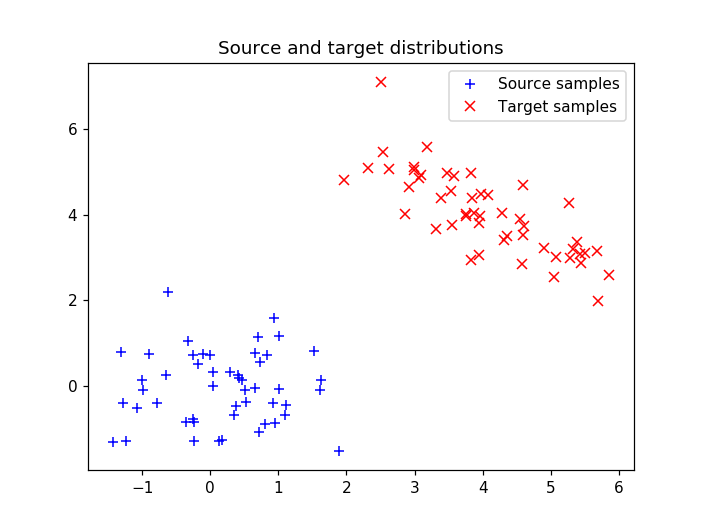

<IPython.core.display.Javascript object>


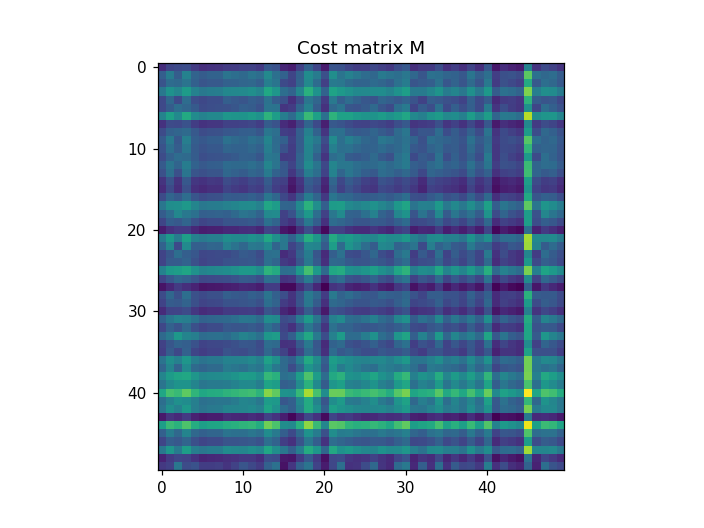

Text(0.5, 1.0, 'Cost matrix M')

In [135]:
plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Cost matrix M')

In [136]:
G0 = ot.emd(a, b, M)

In [139]:
(G0 * M).sum()

0.3712238447242635

<IPython.core.display.Javascript object>


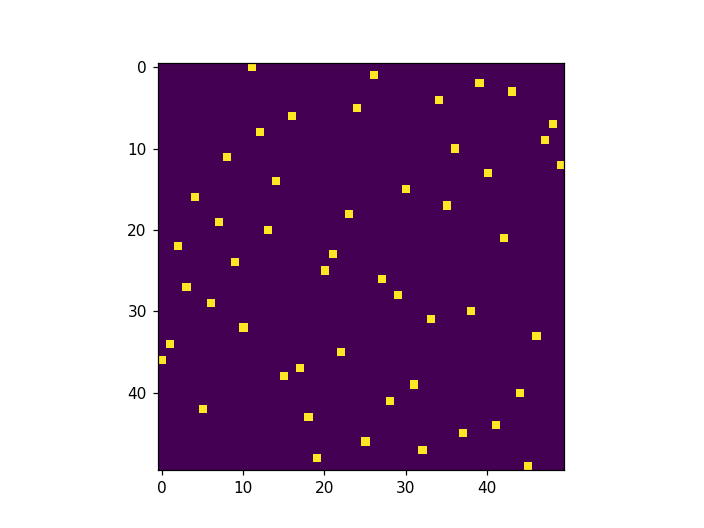

In [138]:
plt.figure()
plt.imshow(G0)

# Wasserstein distance

## MNIST

### Data

In [7]:
ds = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [8]:
train_ds = DWE_dataset(ds, 100000, from_file=pd.read_csv('data/train_MNIST.csv', index_col=0))
# train_ds = DWE_dataset(ds, 100000)
# train_ds.save('data/train_MNIST.csv')

In [9]:
val_ds = DWE_dataset(ds, 10000, from_file=pd.read_csv('data/val_MNIST.csv', index_col=0))
# val_ds = DWE_dataset(ds, 10000)
# val_ds.save('data/val_MNIST.csv')

In [10]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# sampler = torch.utils.data.SubsetRandomSampler(np.arange(100))

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(MNIST("train"), batch_size=16, sampler=sampler, **kwargs)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, **kwargs)

In [11]:
e = EncoderCNN()
d = DecoderCNN()

In [12]:
# dwe = DWE(e, d, 1, cuda=True, lr=1e-3)
dwe = DWE(e, d, 1, cuda=True, lr=1e-3, from_dir='models', name='mnist')

### Training

In [16]:
dwe.train(train_loader, has_y=True, nepochs=10, valloader=val_loader)

Mean train loss : 4.15 (Wasserstein : 2.41 - data : 1.74)
Mean train accuracy : 1.20
Mean train loss : 3.79 (Wasserstein : 2.12 - data : 1.66)
Mean train accuracy : 1.14


Mean train loss : 2.82 (Wasserstein : 1.58 - data : 1.24)
Mean train accuracy : 0.97
Mean train loss : 2.48 (Wasserstein : 1.40 - data : 1.09)
Mean train accuracy : 0.91


Mean train loss : 2.35 (Wasserstein : 1.30 - data : 1.06)
Mean train accuracy : 0.88
Mean train loss : 2.44 (Wasserstein : 1.41 - data : 1.03)
Mean train accuracy : 0.91


Mean train loss : 2.10 (Wasserstein : 1.18 - data : 0.92)
Mean train accuracy : 0.84
Mean train loss : 2.00 (Wasserstein : 1.12 - data : 0.88)
Mean train accuracy : 0.81


Mean train loss : 1.95 (Wasserstein : 1.11 - data : 0.85)
Mean train accuracy : 0.81
Mean train loss : 1.83 (Wasserstein : 1.01 - data : 0.82)
Mean train accuracy : 0.77


Mean train loss : 1.82 (Wasserstein : 1.04 - data : 0.79)
Mean train accuracy : 0.78
Mean train loss : 1.76 (Wasserstein : 1.00 - data : 0.76)
Mean train accuracy : 0.76


Mean train loss : 1.70 (Wasserstein : 0.97 - data : 0.73)
Mean train accuracy : 0.76
Mean train loss : 1.70 (Wasserstein : 1.01 - data : 0.69)
Mean train accuracy : 0.77


Mean train loss : 1.60 (Wasserstein : 0.92 - data : 0.67)
Mean train accuracy : 0.74
Mean train loss : 1.54 (Wasserstein : 0.86 - data : 0.68)
Mean train accuracy : 0.71


Mean train loss : 1.52 (Wasserstein : 0.88 - data : 0.64)
Mean train accuracy : 0.72
Mean train loss : 1.44 (Wasserstein : 0.82 - data : 0.62)
Mean train accuracy : 0.69


Mean train loss : 1.44 (Wasserstein : 0.84 - data : 0.60)
Mean train accuracy : 0.70
Mean train loss : 1.48 (Wasserstein : 0.86 - data : 0.62)
Mean train accuracy : 0.71


In [85]:
dwe.optim.state_dict()['param_groups'][0]['lr'] = 1e-4

In [87]:
dwe.encoder.cuda()
dwe.decoder.cuda();

In [88]:
dwe.train(train_loader, has_y=True, nepochs=5, valloader=val_loader)

Mean train loss : 1.44 (Wasserstein : 0.84 - data : 0.60)
Mean train accuracy : 0.70
Mean train loss : 1.53 (Wasserstein : 0.94 - data : 0.59)
Mean train accuracy : 0.75


Mean train loss : 1.34 (Wasserstein : 0.78 - data : 0.56)
Mean train accuracy : 0.67
Mean train loss : 1.35 (Wasserstein : 0.79 - data : 0.56)
Mean train accuracy : 0.68


Mean train loss : 1.30 (Wasserstein : 0.75 - data : 0.54)
Mean train accuracy : 0.66
Mean train loss : 1.42 (Wasserstein : 0.84 - data : 0.58)
Mean train accuracy : 0.70


Mean train loss : 1.57 (Wasserstein : 0.88 - data : 0.69)
Mean train accuracy : 0.70
Mean train loss : 1.82 (Wasserstein : 1.05 - data : 0.77)
Mean train accuracy : 0.78


Mean train loss : 1.41 (Wasserstein : 0.84 - data : 0.57)
Mean train accuracy : 0.69
Mean train loss : 1.25 (Wasserstein : 0.72 - data : 0.53)
Mean train accuracy : 0.64


In [115]:
dwe.save('models', 'mnist')

In [15]:
# fig, axs = plt.subplots(figsize=(9, 4), ncols=2)
# i = 0
# im = axs[0].imshow(train_ds[i][0][0][0])
# fig.colorbar(im, ax=axs[0])
# im2 = axs[1].imshow(dwe.decoder(dwe.encoder(train_ds[i][0][0][None].cuda())).detach().cpu().numpy()[0, 0])
# fig.colorbar(im2, ax=axs[1])

### Testing

In [16]:
# dwe = DWE(e.cuda(), d.cuda(), 0.1, cuda=True, from_dir='models', name='test')

In [16]:
len_test = 10000
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [17]:
# test_dataset = DWE_dataset(test_ds, len_test)
# test_dataset.save('data/test_MNIST.csv')

In [18]:
test_dataset = DWE_dataset(test_ds, len_test, from_file=pd.read_csv('data/test_MNIST.csv', index_col=0))

In [89]:
preds = []
ys = []
dict_tuple_err = {}
data = np.zeros((len_test*2, 50+1))
with torch.no_grad():
    for i in tqdm.tqdm_notebook(range(len(test_dataset))):
        x1, x2, y = test_dataset[i]
        x1, label_1, x2, label_2 = x1[0], x1[1], x2[0], x2[1]
        if use_cuda:
            x1 = x1.cuda()
            x2 = x2.cuda()
        phi1 = dwe.encoder(x1[None]).detach().cpu().numpy()
        phi2 = dwe.encoder(x2[None]).detach().cpu().numpy()
        data[2*i, :50] = phi1
        data[2*i+1, :50] = phi2
        data[2*i, -1] = label_1
        data[2*i+1, -1] = label_2
        pred = ((phi1 - phi2)**2).sum()
        if (label_1, label_2) not in dict_tuple_err.keys():
            dict_tuple_err[(label_1, label_2)] = [(pred, y)]
        else:
            dict_tuple_err[(label_1, label_2)].append((pred, y))
        preds.append(pred)
        ys.append(y)
preds = np.array(preds)
ys = np.array(ys)

### Speed test

In [107]:
dwe.encoder.cuda()
dwe.decoder.cuda();

In [114]:
# With a CPU
M = train_ds.M
t = 0
for i in tqdm.tqdm_notebook(range(len(val_ds))):
    x1, x2, _ = val_ds[i]
    t0 = time.time()
    compute_dist(x1[0], x2[0], M)
    t += (time.time() - t0)
print(len(val_ds) / t)

136.20837482383865


In [20]:
# With a DWE, CPU
dwe.encoder.cpu()
dwe.decoder.cpu()
dwe.encoder.eval()
dwe.decoder.eval()
t = 0
with torch.no_grad():
    for x1, x2, y in tqdm.tqdm_notebook(val_loader):
        x1 = x1[0]
        x2 = x2[0]
        t0 = time.time()
        phi1 = dwe.encoder(x1)
        phi2 = dwe.encoder(x2)
        d_hat = ((phi1 - phi2)**2).sum(dim=1)
        t += time.time() - t0
print(len(val_ds) / t)


745.5983598451608


In [22]:
# With a DWE, GPU
dwe.encoder.cuda()
dwe.decoder.cuda();
dwe.encoder.eval()
dwe.decoder.eval()
t = 0
with torch.no_grad():
    for x1, x2, y in tqdm.tqdm_notebook(val_loader):
        x1 = x1[0].cuda()
        x2 = x2[0].cuda()
        t0 = time.time()
        phi1 = dwe.encoder(x1)
        phi2 = dwe.encoder(x2)
        d_hat = ((phi1 - phi2)**2).sum(dim=1)
        t += time.time() - t0
print(len(val_ds) / t)


20837.089516981196


### Precision

In [94]:
errors = np.abs(ys - preds)
print(f'MAE = {(errors).mean():.3f}')
print(f'Relative MAE = {((errors)/(ys + 1e-9)).mean():.3f}')
print(f'MSE = {((ys - preds)**2).mean():.3f}')
print(f'Relative MSE = {(((ys - preds)**2)/(ys + 1e-9)).mean():.3f}')
print(f'Correlation = {np.corrcoef(np.stack((preds, ys)))[0, 1]:.3f}')
print(f'Error quantiles : 1% : {np.quantile(errors, 0.01):.2f}| 50% : {np.quantile(errors, 0.5):.2f}| 99% : {np.quantile(errors, 0.99):.2f}')
print(f'Mean distance : {ys.mean():.2f}')

MAE = 0.637
Relative MAE = 0.067
MSE = 0.715
Relative MSE = 0.068
Correlation = 0.990
Error quantiles : 1% : 0.01| 50% : 0.50| 99% : 2.49
Mean distance : 11.21


<IPython.core.display.Javascript object>


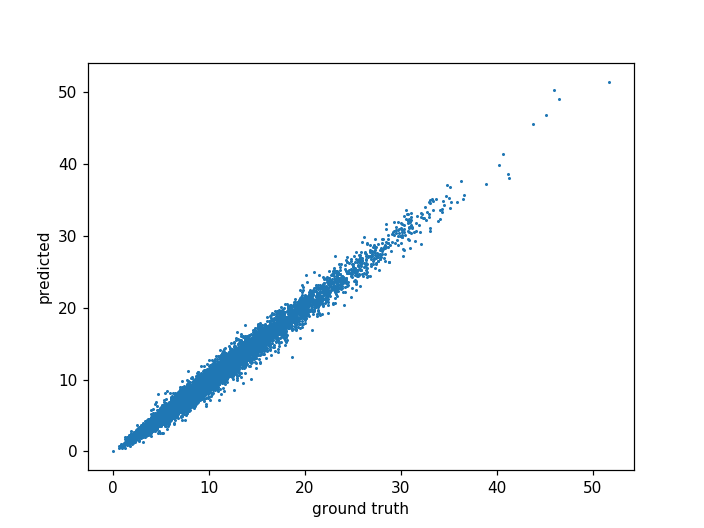

In [95]:
plt.figure()
plt.scatter(ys, preds, s=1)
plt.xlabel('ground truth')
plt.ylabel('predicted')
plt.savefig('figures/corr_preds')

In [24]:
A = np.zeros((2, 10, 10))
for i in range(10):
    for j in range(10):
        pred_dists = np.array([x[0] for x in dict_tuple_err[(i, j)]])
        true_dists = np.array([x[1] for x in dict_tuple_err[(i, j)]])
        A[0, i, j] = pred_dists.mean()
        A[1, i, j] = true_dists.mean()

<IPython.core.display.Javascript object>


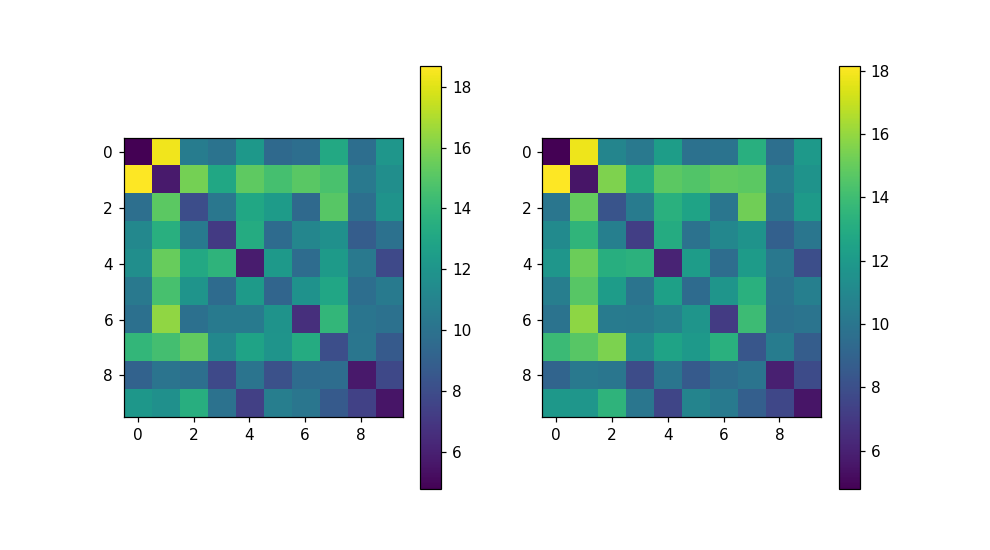

In [25]:
fig, axs = plt.subplots(figsize=(9, 5), ncols=2)
im = axs[0].imshow(A[0])
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(A[1])
fig.colorbar(im, ax=axs[1])

### Latent space

In [64]:
proj = sklearn.decomposition.PCA(n_components=4)
X = proj.fit_transform(data[:,:-1])

<IPython.core.display.Javascript object>


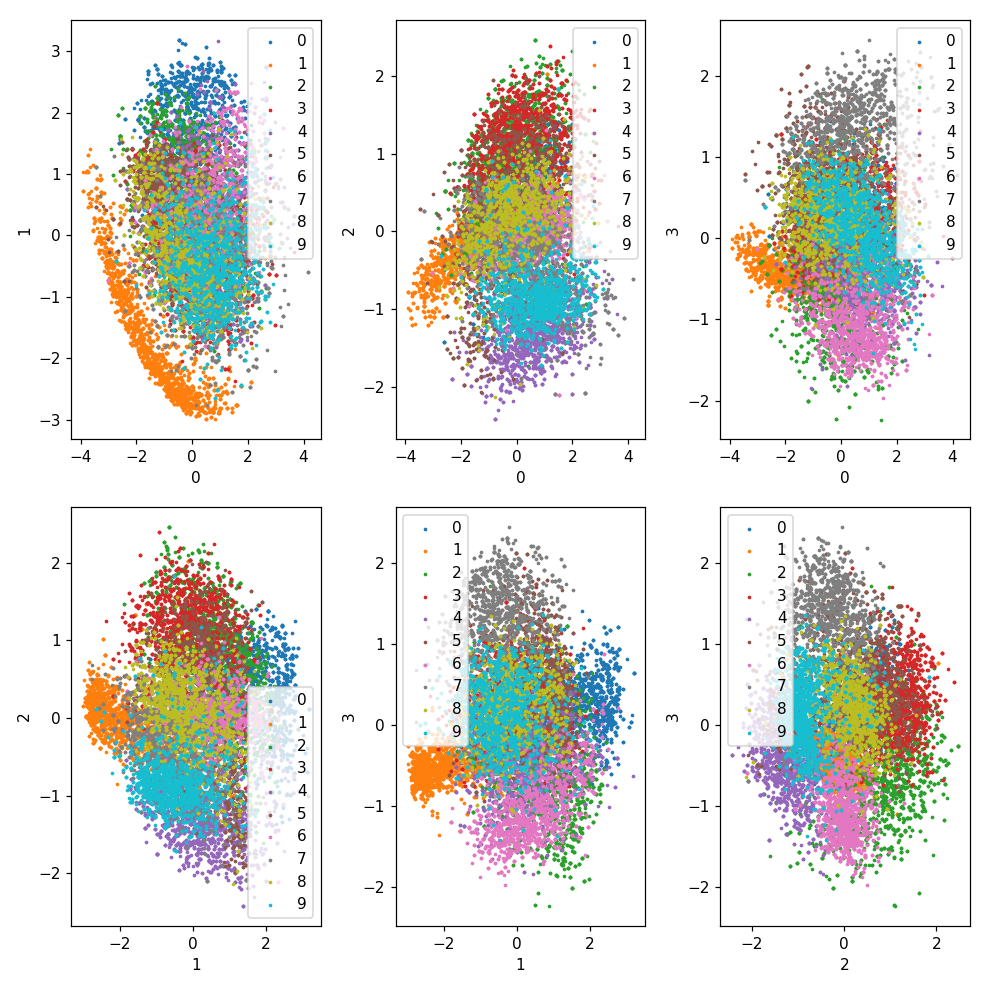

In [65]:
labels = data[:, -1]
dims = {0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (1, 2), 4: (1, 3), 5: (2, 3)}
fig, axs = plt.subplots(figsize=(9, 9), ncols=3, nrows=2)
for k in range(6):
    d1, d2 = dims[k]
    for i in range(10):
        axs[k//3, k%3].scatter(X[labels == i, d1], X[labels == i, d2], label=f'{i}', s=2)
    axs[k//3, k%3].set_xlabel(f'{d1}')
    axs[k//3, k%3].set_ylabel(f'{d2}')
    axs[k//3, k%3].legend()
plt.tight_layout()

# Wasserstein Barycenters

## Digit 0

In [44]:
ds_0 = DigitDataset(test_ds, {0})

In [47]:
avgW_0 = get_avg_digit_W(ds_0, dwe.encoder.cpu(), dwe.decoder.cpu())

<IPython.core.display.Javascript object>


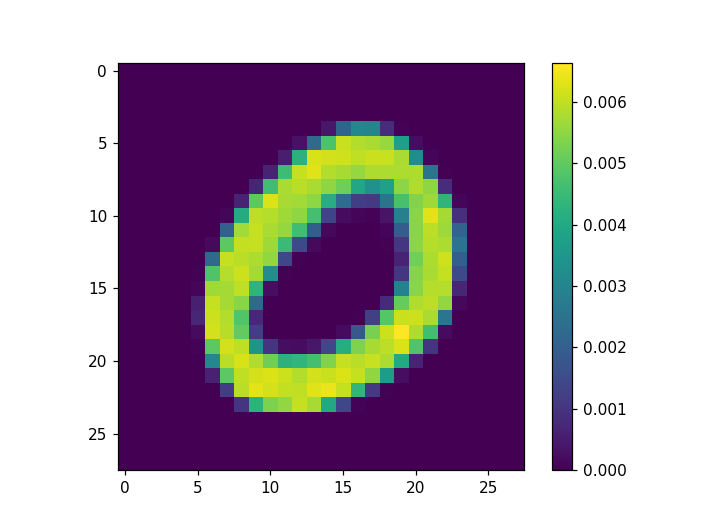

In [48]:
plt.figure()
plt.imshow(avgW_0[0])
plt.colorbar()

In [71]:
avg_0 = get_avg_digit(ds_0)

<IPython.core.display.Javascript object>


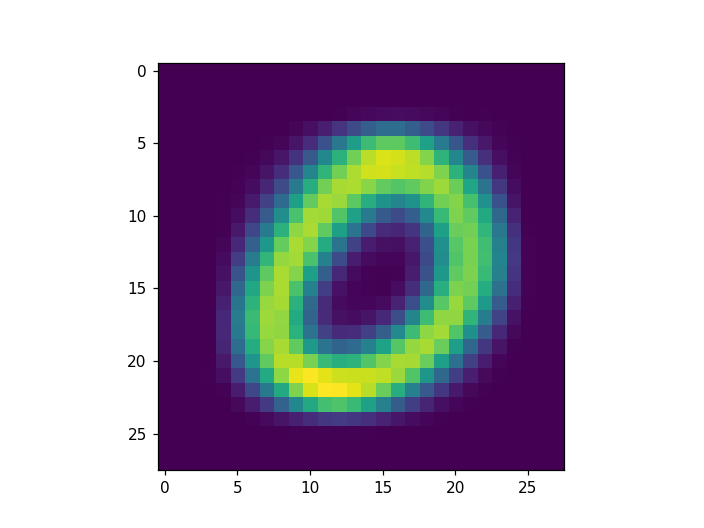

In [72]:
plt.figure()
plt.imshow(avg_0[0])

## All digits

In [24]:
mean_eucl = np.zeros((10, 28, 28))
mean_wass = np.zeros((10, 28, 28))
for i in tqdm.tqdm_notebook(range(10)):
    ds_i = DigitDataset(test_ds, {i})
    avg_iE = get_avg_digit(ds_i)
    avg_iW = get_avg_digit_W(ds_i, dwe.encoder.cpu(), dwe.decoder.cpu())
    mean_eucl[i] = avg_iE
    mean_wass[i] = avg_iW

<IPython.core.display.Javascript object>


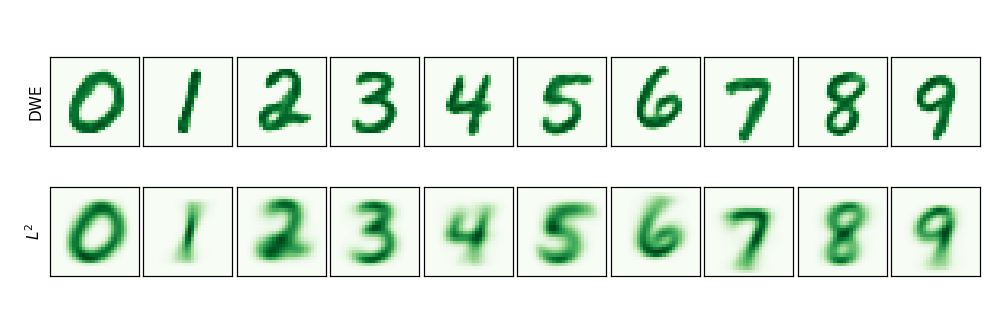

In [142]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=10, nrows=2)
for i in range(10):
    axs[0, i].imshow(mean_wass[i], cmap='Greens', interpolation='nearest')
    axs[1, i].imshow(mean_eucl[i], cmap='Greens', interpolation='nearest')
    plt.setp(axs[0, i].get_xticklabels(), visible=False)
    plt.setp(axs[0, i].get_yticklabels(), visible=False)
    axs[0, i].tick_params(axis='both', which='both', length=0)
    plt.setp(axs[1, i].get_xticklabels(), visible=False)
    plt.setp(axs[1, i].get_yticklabels(), visible=False)
    axs[1, i].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_ylabel('DWE')
axs[1, 0].set_ylabel(r'$L^2$')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99)
plt.savefig('figures/Wbarycenters')

## Interpolation

In [13]:
ds_0 = DigitDataset(test_ds, {0})
ds_1 = DigitDataset(test_ds, {1})
ds_3 = DigitDataset(test_ds, {3})
ds_5 = DigitDataset(test_ds, {5})

In [14]:
dwe.encoder.cpu()
dwe.decoder.cpu();

In [15]:
N = 5

In [16]:
M = np.array([
    [1, 0.75, 0.5, 0.25, 0],
    [0.75, 0.5625, 0.375, 0.1875, 0],
    [0.5, 0.375, 0.25, 0.125, 0],
    [0.25, 0.1875, 0.125, 0.0625, 0],
    [0, 0, 0, 0, 0]
])

In [17]:
M

array([[1.    , 0.75  , 0.5   , 0.25  , 0.    ],
       [0.75  , 0.5625, 0.375 , 0.1875, 0.    ],
       [0.5   , 0.375 , 0.25  , 0.125 , 0.    ],
       [0.25  , 0.1875, 0.125 , 0.0625, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [18]:
alphas = np.stack([M, np.flip(M, axis=1), np.flip(M, axis=0), np.flip(M)])

In [19]:
alphas.sum(0)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

<IPython.core.display.Javascript object>


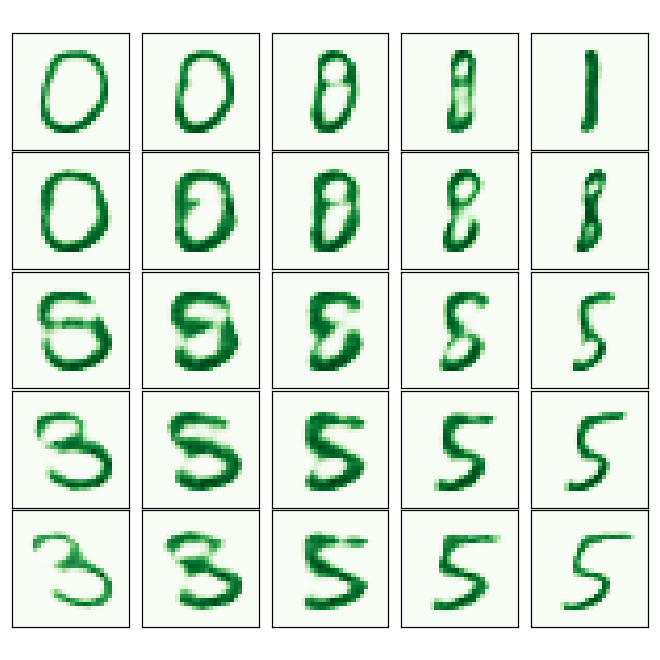

In [36]:
a, b, c, d = 1, 2, 0, 2
latent_imgs = dwe.encoder(torch.stack([ds_0[a], ds_1[b], ds_3[c], ds_5[d]]))
fig, axs = plt.subplots(figsize=(6, 6), ncols=N, nrows=N)
for i in range(N):
    for j in range(N):
        weights = alphas[:, i, j]
        latent = torch.stack([weights[k] * latent_imgs[k] for k in range(4)]).sum(dim=0)[None]
        im = dwe.decoder(latent)[0].detach().numpy()
        axs[i, j].imshow(im[0], cmap='Greens', interpolation='nearest')
        plt.setp(axs[i, j].get_xticklabels(), visible=False)
        plt.setp(axs[i, j].get_yticklabels(), visible=False)
        axs[i, j].tick_params(axis='both', which='both', length=0)
plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.95, bottom=0.05)
plt.savefig('figures/Wbarycenters_square')

# Principal Geodesic Analysis

## Digit 0

In [30]:
ds_0 = DigitDataset(test_ds, {0})

In [32]:
ds_0[0].shape

torch.Size([1, 28, 28])

In [35]:
zeros = torch.stack([ds_0[i] for i in range(len(ds_0))])

In [48]:
latent_zeros = dwe.encoder(zeros).detach().cpu().numpy()

In [49]:
mean_l_zeros = latent_zeros.mean(axis=0)

In [50]:
latent_zeros -= mean_l_zeros[None]

In [51]:
latent_zeros.shape

(980, 50)

In [53]:
latent_cov = np.cov(latent_zeros.T)
latent_cov.shape

(50, 50)

In [54]:
eigs, V = np.linalg.eig(latent_cov)

In [62]:
alphas = np.linspace(-1.5, 1.5, 11)
alphas

array([-1.5, -1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2,  1.5])

<IPython.core.display.Javascript object>


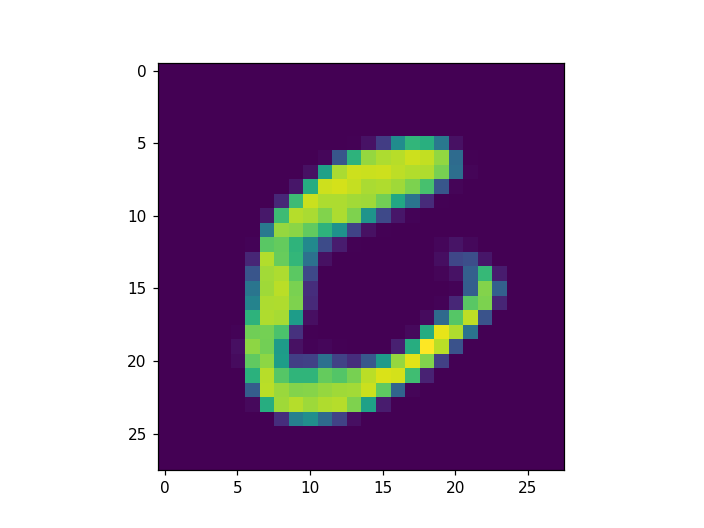

<IPython.core.display.Javascript object>


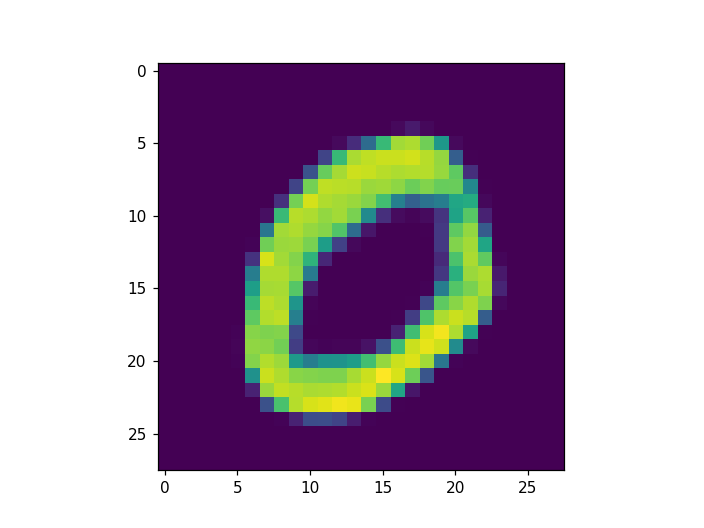

<IPython.core.display.Javascript object>


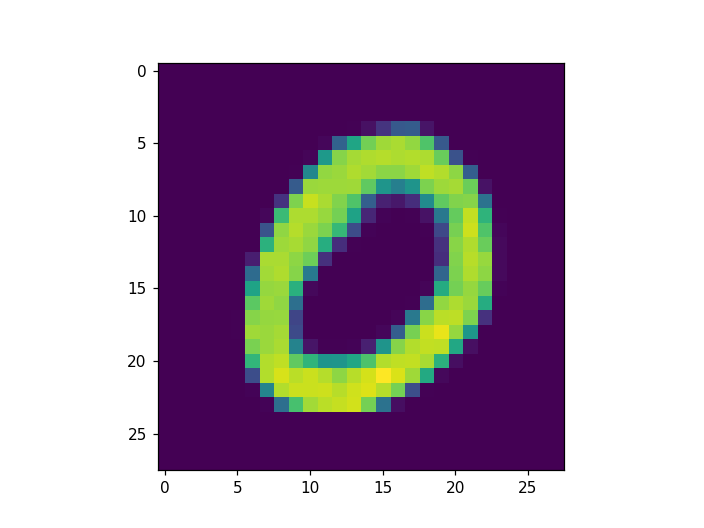

<IPython.core.display.Javascript object>


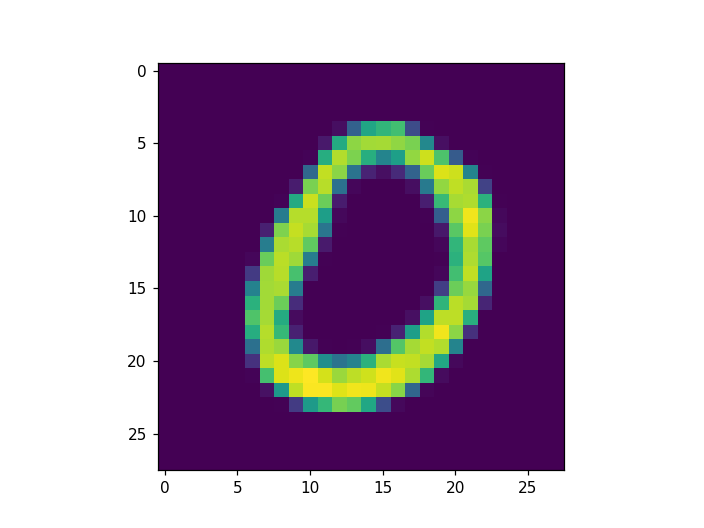

<IPython.core.display.Javascript object>


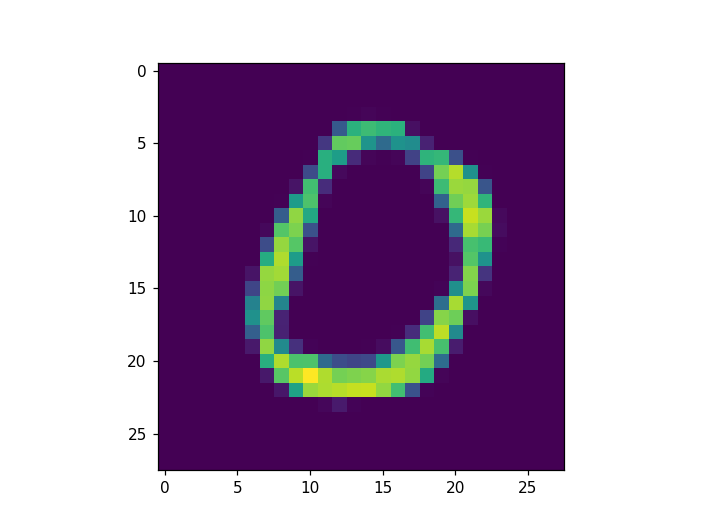

In [59]:
eigval = 0
for i in range(5):
    embed = mean_l_zeros + alphas[i] * V[eigval]
    im = dwe.decoder(torch.tensor(embed).float()[None]).detach()
    plt.figure()
    plt.imshow(im[0, 0], cmap='Greens', interpolation='nearest')

## Digits 1, 2, 3

In [75]:
stacked_digit.mean(dim=0)

torch.Size([1, 28, 28])

In [126]:
digits = np.arange(10)
alphas = np.linspace(-1.5, 1.5, 7)
embeds = np.arange(3)
d2imgs = {}
pbar = tqdm.tqdm_notebook()
for i, d in enumerate(digits):
    imgs = {}
    ds_d = DigitDataset(test_ds, {d})
    stacked_digit = torch.stack([ds_d[k] for k in range(len(ds_d))])
    # PCA
    mean_digit = stacked_digit.mean(dim=0)
    vector_digit = (stacked_digit - mean_digit[None]).numpy().reshape(-1, 28*28)
    digit_cov = np.cov(vector_digit.T)
    eigs_d, V_d = np.linalg.eig(digit_cov)
    
    # PGA
    latent_digit = dwe.encoder(stacked_digit).detach().cpu().numpy()
    latent_mean = latent_digit.mean(axis=0)
    latent_digit -= latent_mean[None]
    latent_cov = np.cov(latent_digit.T)
    eigs, V = np.linalg.eig(latent_cov)
    
    for method in ['PCA', 'PGA']:
        for dim in embeds:
            for j, alpha in enumerate(alphas):
                if method == 'PGA':
                    embed = latent_mean + alpha * V[:, dim] * np.sqrt(eigs[dim])
                    im = dwe.decoder(torch.tensor(embed).float()[None]).detach()[0, 0]
                else:
                    im = mean_digit.numpy()[0] + alpha * V_d.real[:, dim].reshape(28, 28) * np.sqrt(eigs_d.real[dim])
                imgs[(method, dim, j)] = im
                pbar.update(1)
    d2imgs[d] = imgs
pbar.close()

In [116]:
np.argmin(eigs.cumsum() / eigs.sum() < 0.99) / eigs.size

0.32

In [117]:
np.argmin(eigs_d.cumsum() / eigs_d.sum() < 0.99) / eigs_d.size

0.2602040816326531

<IPython.core.display.Javascript object>


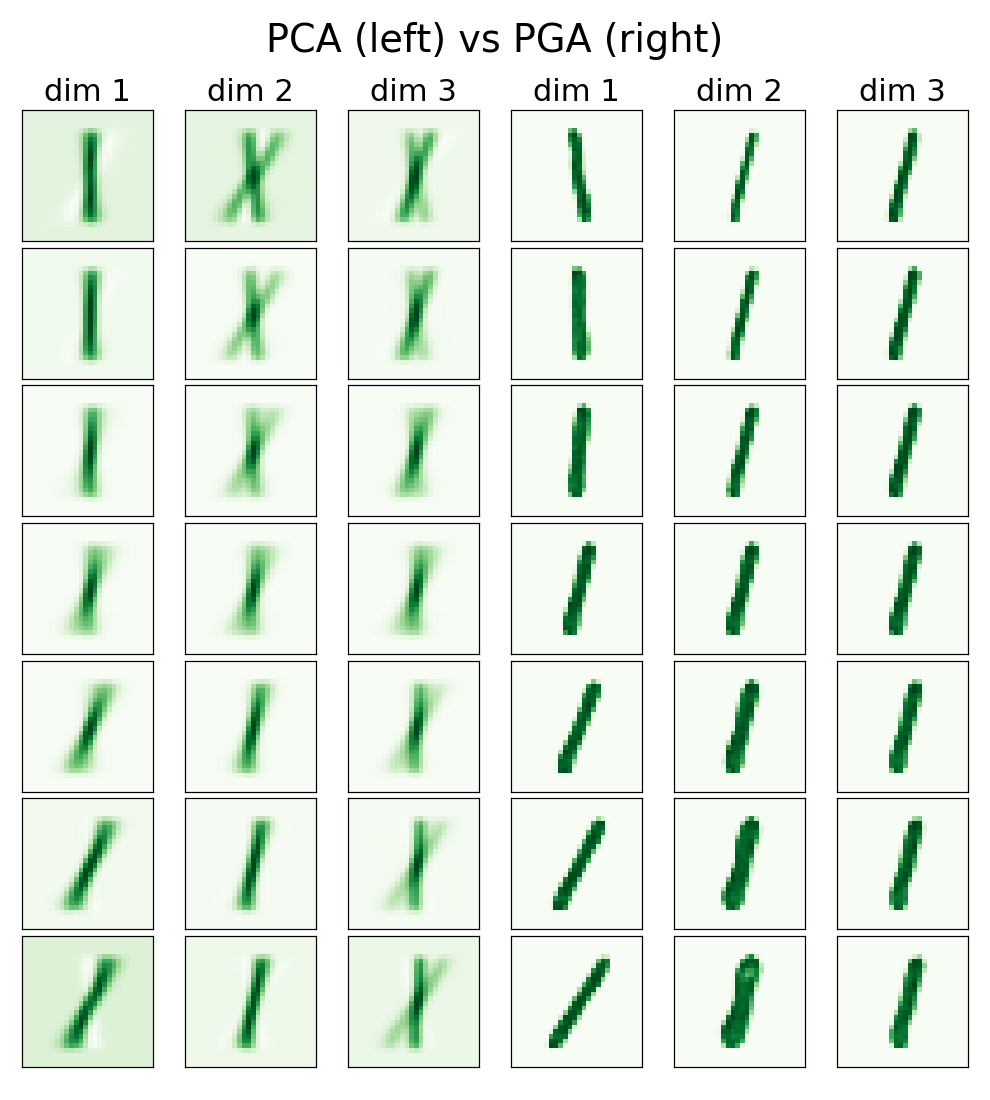

<IPython.core.display.Javascript object>


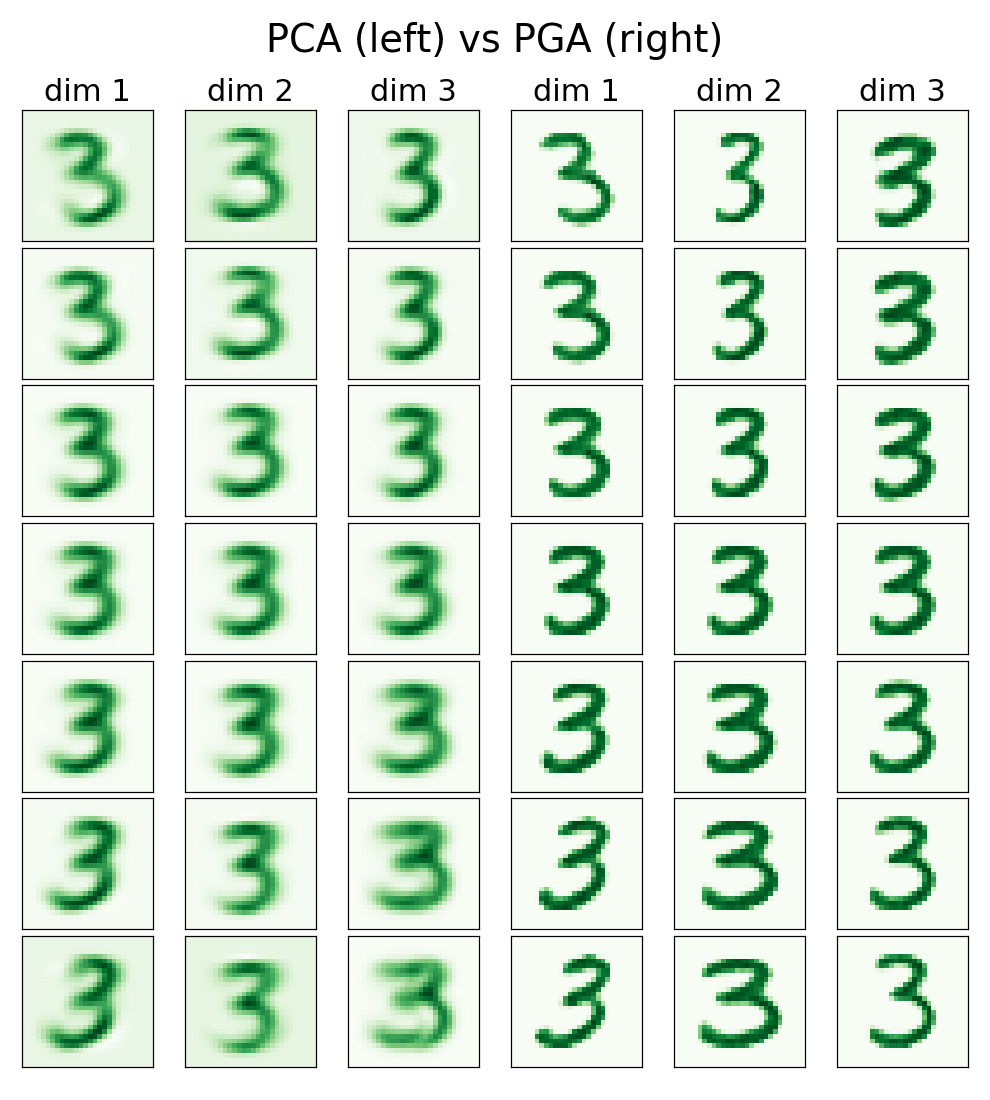

<IPython.core.display.Javascript object>


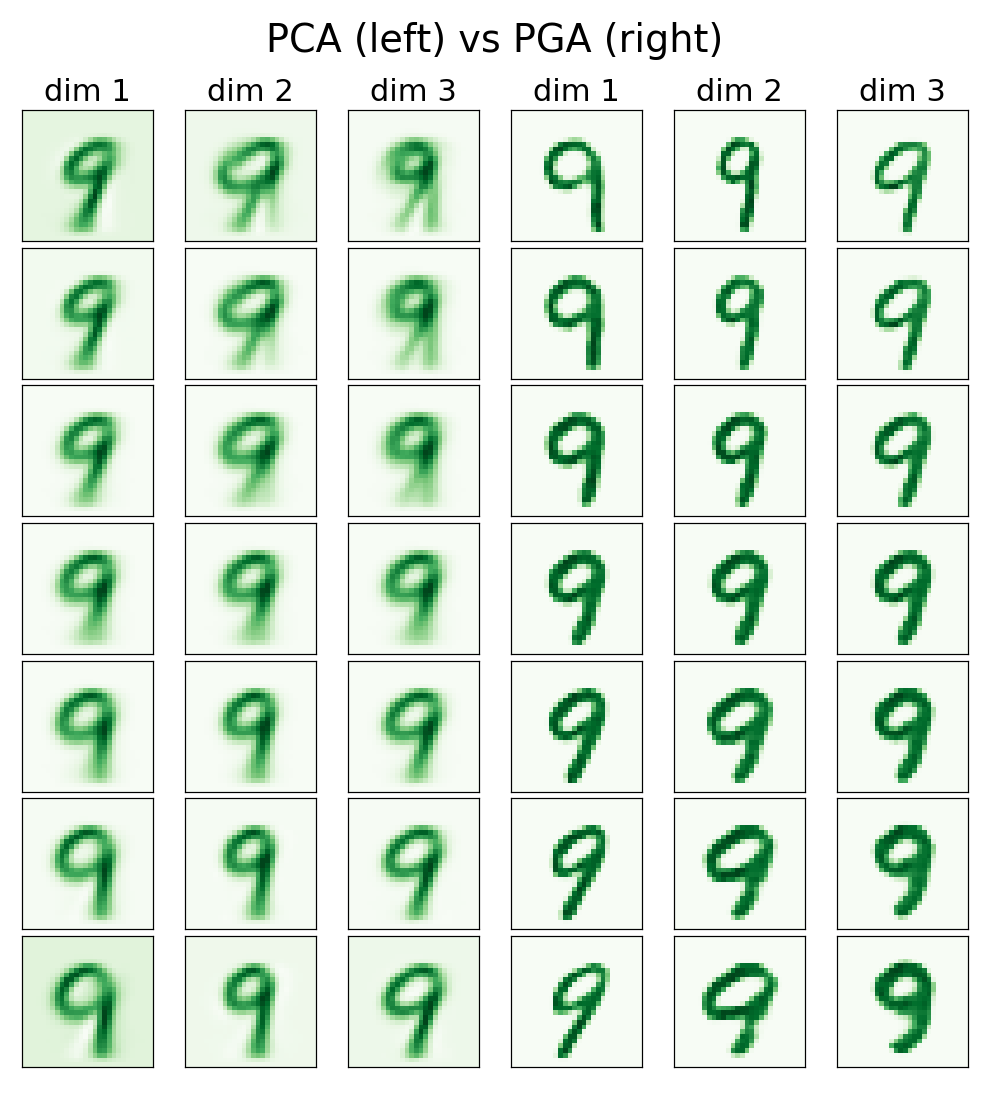

In [144]:
m2i = {'PCA': 0, 'PGA': 1}
digits = [1, 3, 9]
for digit in digits:
    fig, axs = plt.subplots(figsize=(9, 10), ncols=2 * len(embeds), nrows=len(alphas))
    for k, im in d2imgs[digit].items():
        method, dim, j = k
        ax = (j, len(embeds) * m2i[method] + dim)
        axs[ax].imshow(im, cmap='Greens', interpolation='nearest')
        plt.setp(axs[ax].get_xticklabels(), visible=False)
        plt.setp(axs[ax].get_yticklabels(), visible=False)
        axs[ax].tick_params(axis='both', which='both', length=0)
    for i in range(len(embeds)):
        axs[0, i].set_title(f'dim {i+1}', fontsize=20)
        axs[0, i+len(embeds)].set_title(f'dim {i+1}', fontsize=20)
    plt.suptitle('PCA (left) vs PGA (right)', fontsize=25)
    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99, bottom=0.03, top=0.9)
    plt.savefig(f'figures/PGA_{digit}')

# Wasserstein k-means

In [14]:
dwe.encoder.cpu()
dwe.decoder.cpu();

In [17]:
algo = WKmeans(dwe.encoder, dwe.decoder)

## Zeros

In [17]:
ds_0 = DigitDataset(test_ds, {0})

In [25]:
# algo = WKmeans(dwe_smaller.encoder, dwe_smaller.decoder)

In [27]:
k = 3
algo.fit(ds_0, k, has_y=False, max_iter=2000, lr=0.3)

In [28]:
algo.Ls

array([1.55526102, 1.55575609, 1.55529416, 1.55575669, 1.55526054,
       1.55526137, 1.55526173, 1.55589557, 1.55575728, 1.5557574 ])

In [29]:
pd.value_counts(algo.assignment)

0    348
1    328
2    304
dtype: int64

<IPython.core.display.Javascript object>


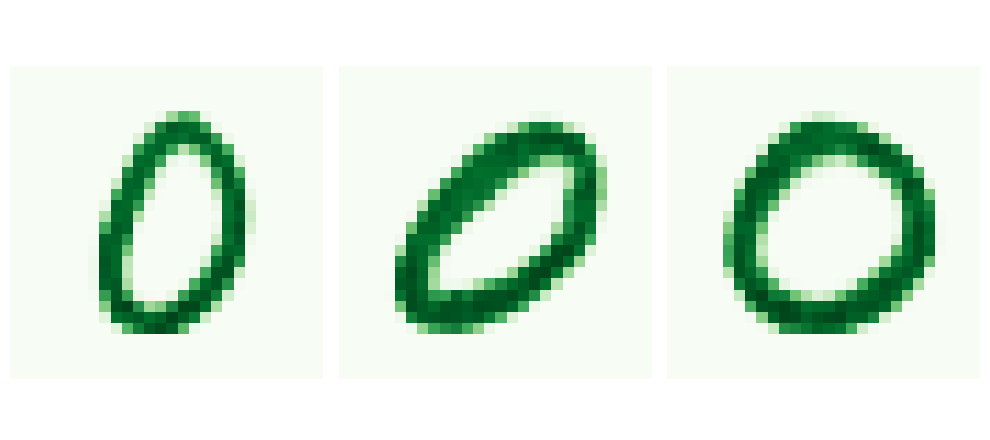

In [31]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)

In [32]:
dists = np.copy(algo.dists2centroids)

<IPython.core.display.Javascript object>


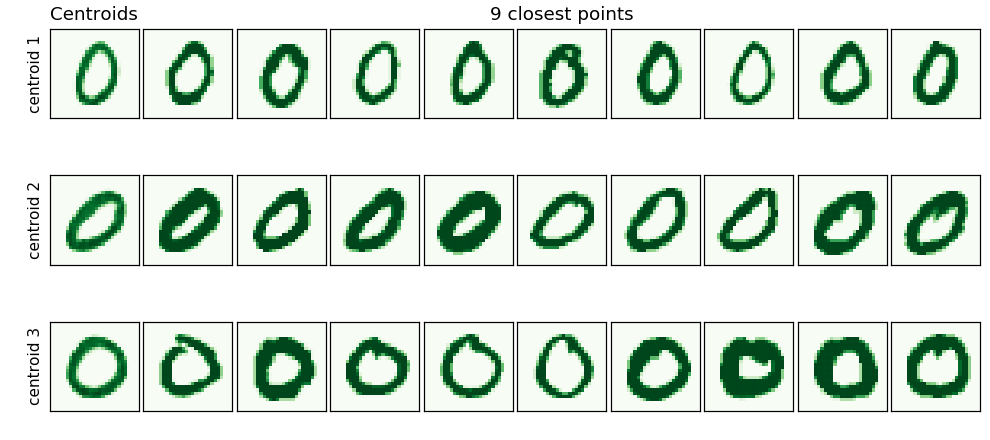

In [33]:
m = 9
fig, axs = plt.subplots(figsize=(9, 4), ncols=m+1, nrows=k)
for i in range(k):
#     im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i, 0].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[i, 0].get_xticklabels(), visible=False)
    plt.setp(axs[i, 0].get_yticklabels(), visible=False)
    axs[i, 0].tick_params(axis='both', which='both', length=0)
    axs[i, 0].set_ylabel(f'centroid {i+1}')
    chosen = np.argsort(dists[:, i])[:m]
    for j in range(1, m+1):
        axs[i, j].imshow(ds_0[chosen[j-1]][0].numpy(), cmap='Greens', interpolation='nearest')
        plt.setp(axs[i, j].get_xticklabels(), visible=False)
        plt.setp(axs[i, j].get_yticklabels(), visible=False)
        axs[i, j].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_title('Centroids')
axs[0, 1 + m//2].set_title(f'{m} closest points')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99, top=0.99, bottom=0.01)

## Ones

In [591]:
ds = DigitDataset(test_ds, {1})

In [592]:
k = 3
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [593]:
algo.Ls

array([0.60599703, 0.60614073, 0.60600317, 0.60614067, 0.60600197,
       0.60600001, 0.60614336, 0.60599929, 0.60605568, 0.60614312])

In [594]:
pd.value_counts(algo.assignment)

1    419
0    408
2    308
dtype: int64

<IPython.core.display.Javascript object>


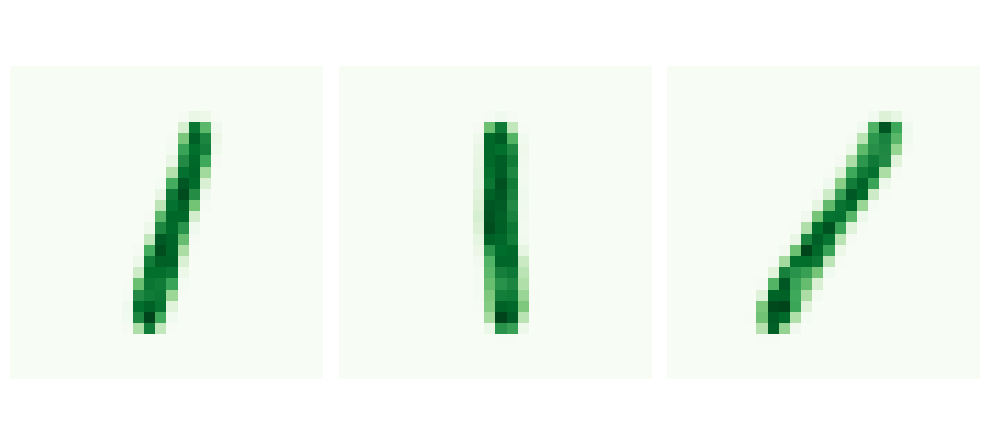

In [595]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
    im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)

In [596]:
dists = np.copy(algo.dists2centroids)

<IPython.core.display.Javascript object>


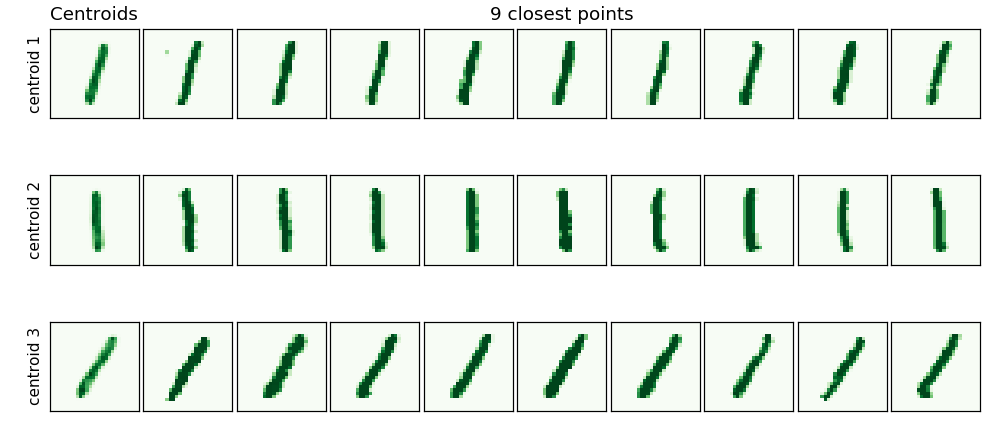

In [597]:
m = 9
fig, axs = plt.subplots(figsize=(9, 4), ncols=m+1, nrows=k)
for i in range(k):
#     im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i, 0].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[i, 0].get_xticklabels(), visible=False)
    plt.setp(axs[i, 0].get_yticklabels(), visible=False)
    axs[i, 0].tick_params(axis='both', which='both', length=0)
    axs[i, 0].set_ylabel(f'centroid {i+1}')
    chosen = np.argsort(dists[:, i])[:m]
    for j in range(1, m+1):
        axs[i, j].imshow(ds[chosen[j-1]][0].numpy(), cmap='Greens', interpolation='nearest')
        plt.setp(axs[i, j].get_xticklabels(), visible=False)
        plt.setp(axs[i, j].get_yticklabels(), visible=False)
        axs[i, j].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_title('Centroids')
axs[0, 1 + m//2].set_title(f'{m} closest points')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99, top=0.99, bottom=0.01)

## 0 and 1

### k=2

In [18]:
ds = DigitDataset(test_ds, {0, 1})

In [32]:
k = 2
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [20]:
algo.Ls

array([2.72242951, 2.72243738, 2.72242999, 2.7224319 , 2.7224319 ,
       2.72242999, 2.72243071, 2.72242999, 2.72242904, 2.72242975])

In [21]:
pd.value_counts(algo.assignment)

0    1142
1     973
dtype: int64

<IPython.core.display.Javascript object>


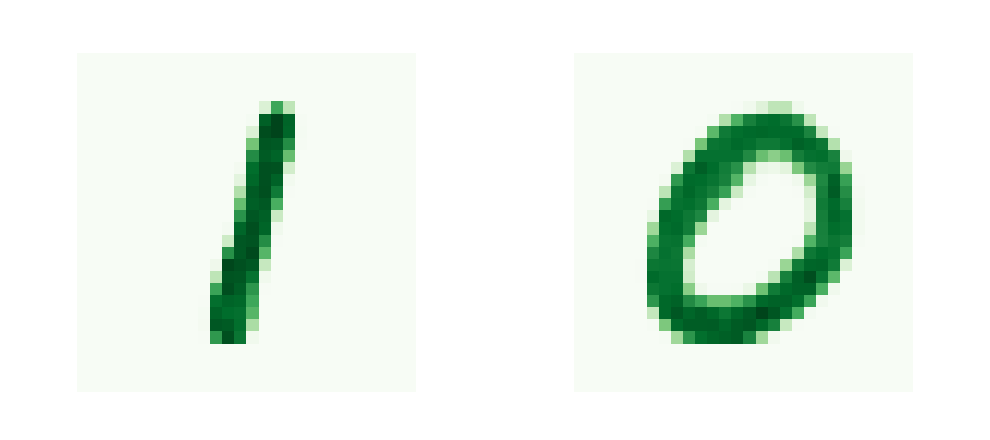

In [22]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
    im = decode_latent(dwe.decoder, algo.centroids[i])[0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)
plt.savefig('figures/wkmeans_01_centroids')

<IPython.core.display.Javascript object>


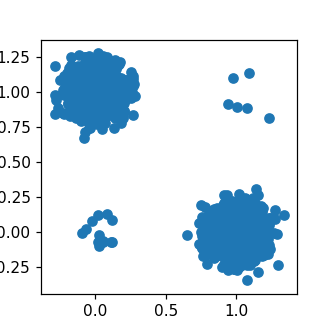

In [23]:
plt.figure(figsize=(3, 3))
eps = 0.1
plt.scatter(ds.labels+np.random.randn(len(ds.labels)) * eps, algo.assignment+np.random.randn(len(ds.labels))*eps)

In [24]:
assignment2label = {0: 1, 1: 0}
assign_l = np.array([assignment2label[x] for x in algo.assignment])
acc = (assign_l == ds.labels).mean()
print(f'Mean accuracy : {acc:.3f}')

Mean accuracy : 0.991


<IPython.core.display.Javascript object>


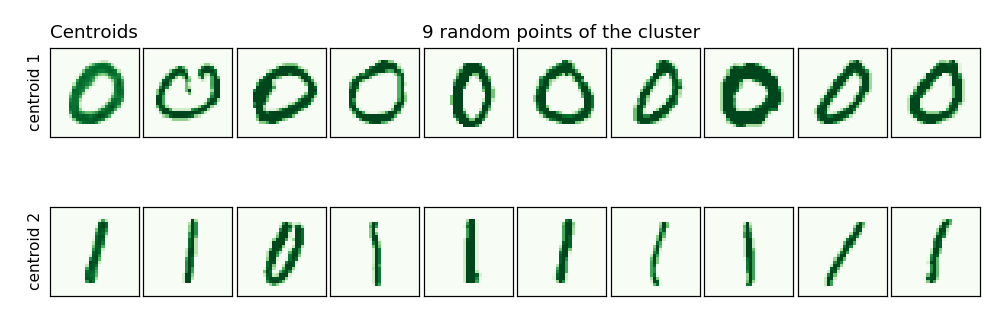

In [33]:
plot_clusters(ds, algo, dwe.decoder, m=9, random=True);
plt.savefig('figures/wkmeans_01_k2')

### k=6

In [34]:
k = 6
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [27]:
algo.Ls

array([1.29660654, 1.29660678, 1.29615486, 1.39384449, 1.40463245,
       1.2959553 , 1.29588914, 1.40102875, 1.29622293, 1.29622149])

In [28]:
pd.value_counts(algo.assignment)

2    418
4    413
1    348
5    329
3    304
0    303
dtype: int64

<IPython.core.display.Javascript object>


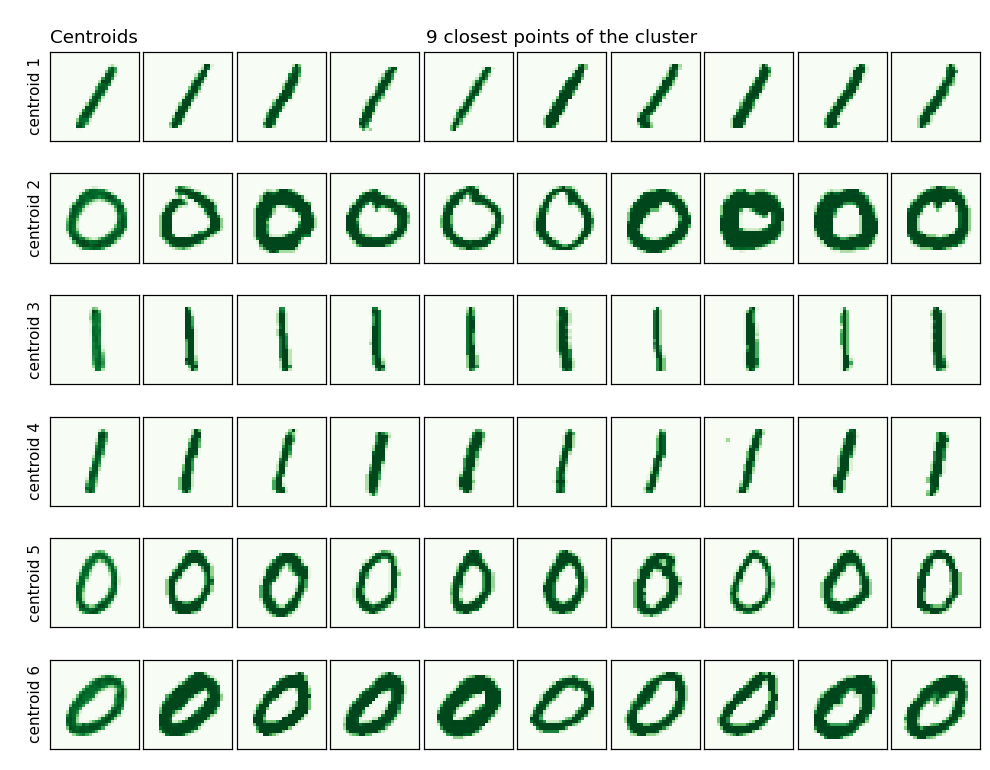

In [35]:
plot_clusters(ds, algo, dwe.decoder, m=9, random=False);
plt.savefig('figures/wkmeans_01_k6')

## 0, 1, 2

In [75]:
ds = DigitDataset(test_ds, {0, 1, 2})

In [76]:
k = 3
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [77]:
algo.Ls

array([3.15487647, 3.15487194, 3.15465307, 3.1546526 , 3.15472603,
       3.20704246, 3.15469646, 3.15465283, 3.15471339, 3.15487123])

In [78]:
pd.value_counts(algo.assignment)

0    1199
1    1139
2     809
dtype: int64

<IPython.core.display.Javascript object>


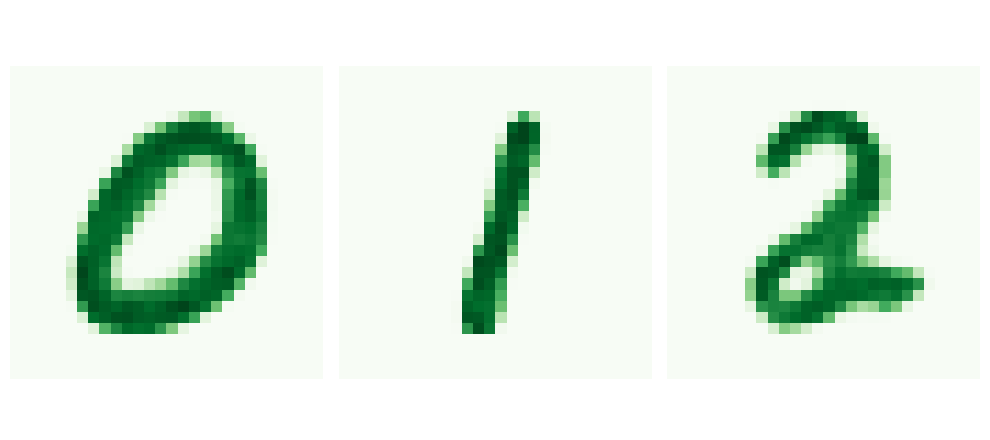

In [80]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)

In [81]:
dists = np.copy(algo.dists2centroids)

<IPython.core.display.Javascript object>


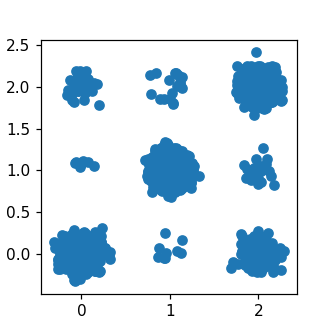

In [82]:
plt.figure(figsize=(3, 3))
eps = 0.1
plt.scatter(ds.labels+np.random.randn(len(ds.labels)) * eps, algo.assignment+np.random.randn(len(ds.labels))*eps)

In [83]:
assignment2label = {0: 0, 1: 1, 2: 2}
assign_l = np.array([assignment2label[x] for x in algo.assignment])
acc = (assign_l == ds.labels).mean()
print(f'Mean accuracy : {acc:.3f}')

Mean accuracy : 0.885


<IPython.core.display.Javascript object>


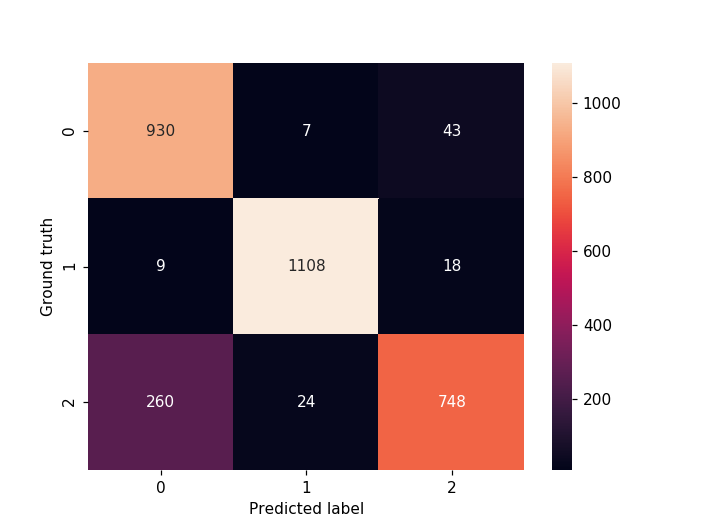

Text(50.722222222222214, 0.5, 'Ground truth')

In [95]:
plt.figure()
sns.heatmap(sklearn.metrics.confusion_matrix(ds.labels, assign_l),
            xticklabels=np.arange(3), yticklabels=np.arange(3), annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Ground truth')

<IPython.core.display.Javascript object>


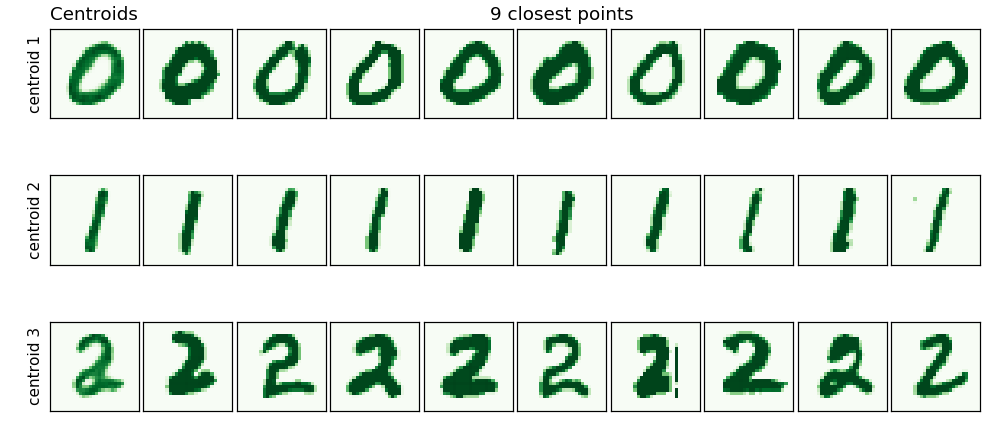

In [97]:
m = 9
fig, axs = plt.subplots(figsize=(9, 4), ncols=m+1, nrows=k)
for i in range(k):
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i, 0].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[i, 0].get_xticklabels(), visible=False)
    plt.setp(axs[i, 0].get_yticklabels(), visible=False)
    axs[i, 0].tick_params(axis='both', which='both', length=0)
    axs[i, 0].set_ylabel(f'centroid {i+1}')
    chosen = np.argsort(dists[:, i])[:m]
    for j in range(1, m+1):
        axs[i, j].imshow(ds[chosen[j-1]][0].numpy(), cmap='Greens', interpolation='nearest')
        plt.setp(axs[i, j].get_xticklabels(), visible=False)
        plt.setp(axs[i, j].get_yticklabels(), visible=False)
        axs[i, j].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_title('Centroids')
axs[0, 1 + m//2].set_title(f'{m} closest points')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99, top=0.99, bottom=0.01)

## 0, 1, 2, 3, 4

In [36]:
ds = DigitDataset(test_ds, {0, 1, 2, 3, 4})

In [52]:
k = 3
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [46]:
algo.Ls

array([3.00717211, 2.97843957, 2.97844958, 3.00757885, 3.00717354,
       2.97845197, 2.97844958, 3.00757885, 2.97844958, 3.14512634])

In [54]:
pd.value_counts(algo.assignment)

0    2077
1    1796
2    1266
dtype: int64

<IPython.core.display.Javascript object>


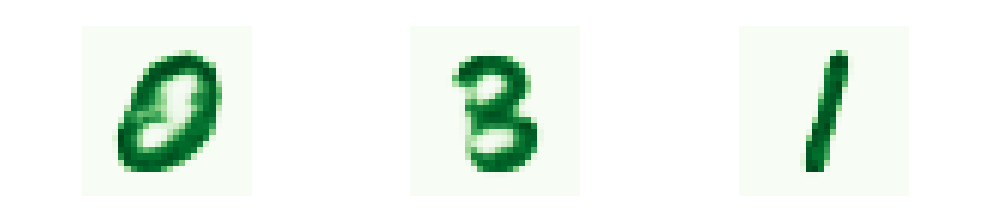

In [53]:
fig, axs = plt.subplots(figsize=(9, 2), ncols=k)
for i in range(k):
    im = decode_latent(dwe.decoder, algo.centroids[i])[0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)
# plt.savefig('figures/wkmeans_01234_k3_c')

In [41]:
dists = np.copy(algo.dists2centroids)

<IPython.core.display.Javascript object>


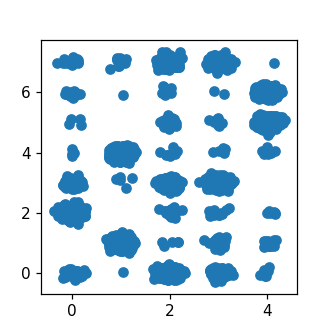

In [42]:
plt.figure(figsize=(3, 3))
eps = 0.1
plt.scatter(ds.labels+np.random.randn(len(ds.labels)) * eps, algo.assignment+np.random.randn(len(ds.labels))*eps)

In [108]:
assignment2label = {3: 1, 1: 4, 0: 1, 2: 3, 4: 0}
assign_l = np.array([assignment2label[x] for x in algo.assignment])
acc = (assign_l == ds.labels).mean()
print(f'Mean accuracy : {acc:.3f}')

Mean accuracy : 0.709


<IPython.core.display.Javascript object>


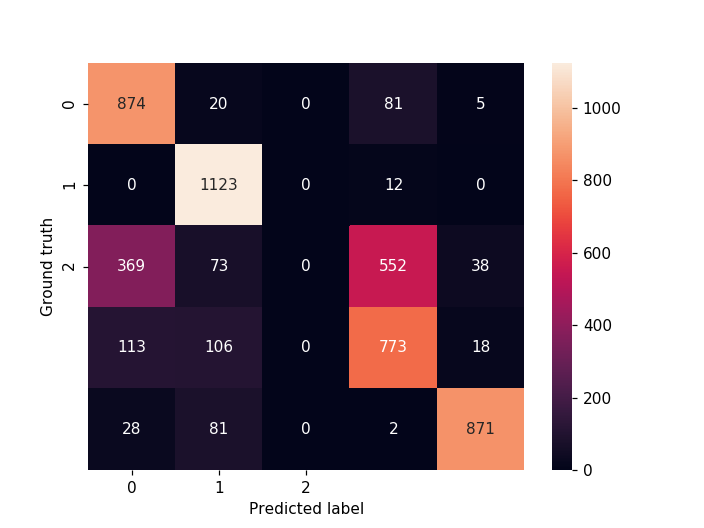

Text(50.722222222222214, 0.5, 'Ground truth')

In [109]:
plt.figure()
sns.heatmap(sklearn.metrics.confusion_matrix(ds.labels, assign_l),
            xticklabels=np.arange(3), yticklabels=np.arange(3), annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Ground truth')

<IPython.core.display.Javascript object>


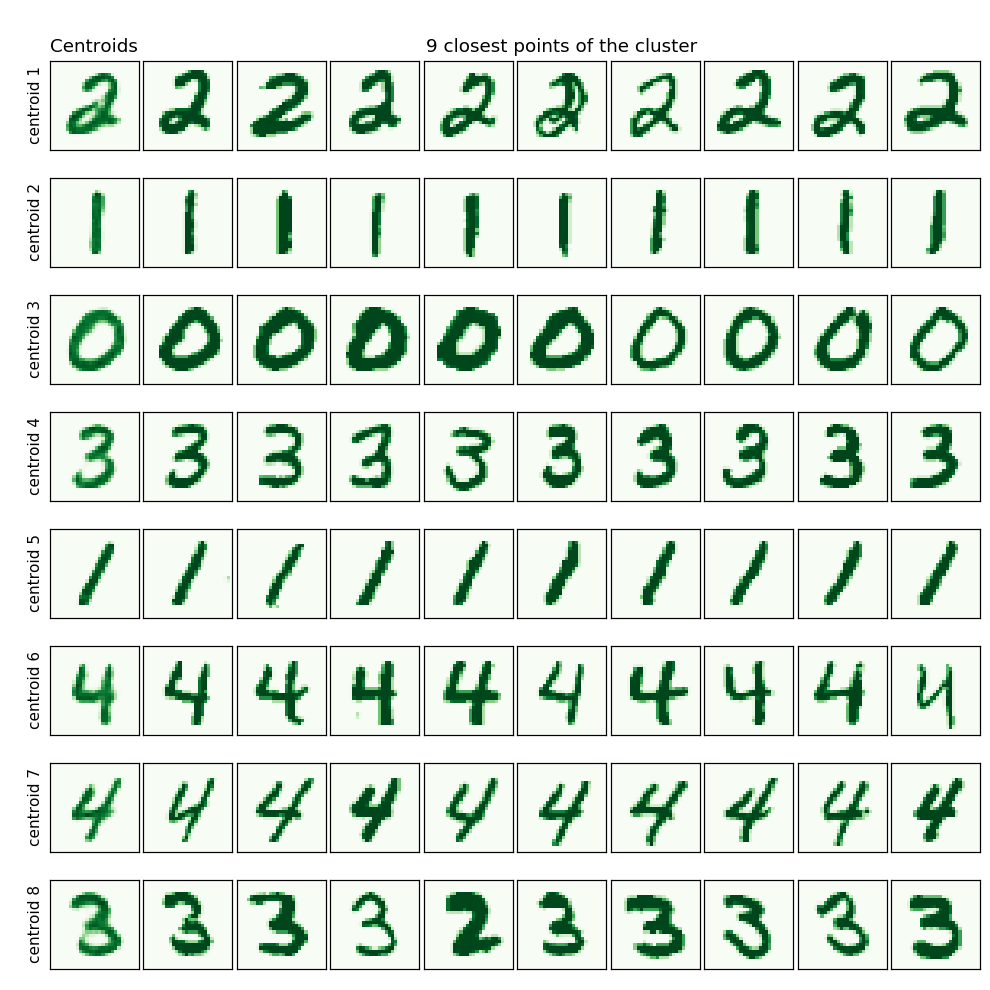

In [43]:
plot_clusters(ds, algo, dwe.decoder, m=9, random=False);
# plt.savefig('figures/wkmeans_01234_k8')

## 0, 1, 2, 3, 4, 5, 6

In [110]:
ds = DigitDataset(test_ds, {0, 1, 2, 3, 4, 5, 6})

In [112]:
k = 7
algo.fit(ds, k, has_y=False, max_iter=2000, lr=0.3)

In [113]:
algo.Ls

array([2.88171601, 2.88751125, 2.9351263 , 2.88172674, 2.88170958,
       2.88742304, 2.88171935, 2.88187838, 2.88751125, 2.91318107])

In [114]:
pd.value_counts(algo.assignment)

5    1345
4    1166
3     967
2     935
1     902
6     865
0     809
dtype: int64

<IPython.core.display.Javascript object>


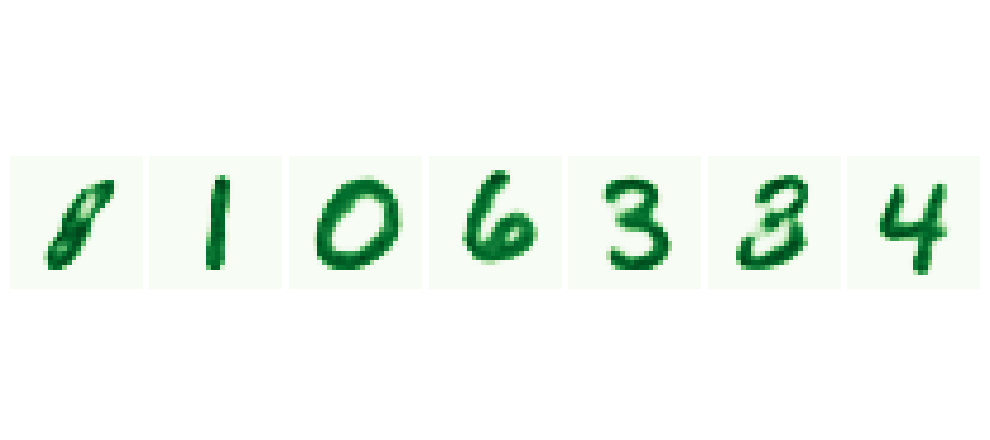

In [115]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)

In [116]:
dists = np.copy(algo.dists2centroids)

In [121]:
for i in range(7):
    print(i)
    id_i = (algo.assignment == i)
    print(pd.value_counts(ds.labels[id_i]))
    print()

0
1    350
5    227
4    126
6     43
0     31
2     17
3     15
dtype: int64

1
1    769
6     43
3     43
5     18
4     18
2     10
0      1
dtype: int64

2
0    784
6     50
2     49
5     32
4     11
3      9
dtype: int64

3
6    722
2    190
4     33
0     11
3      6
5      3
1      2
dtype: int64

4
3    562
5    287
2    246
0     52
1     13
6      4
4      2
dtype: int64

5
2    509
3    368
5    279
0     98
6     88
4      2
1      1
dtype: int64

6
4    790
5     46
2     11
6      8
3      7
0      3
dtype: int64



In [131]:
assignment2label = {0: 5, 1: 1, 2: 0, 3: 6, 4: 3, 5: 2, 6: 4}
label2assignment = {v: k for k, v in assignment2label.items()}
assign_l = np.array([assignment2label[x] for x in algo.assignment])
acc = (assign_l == ds.labels).mean()
print(f'Mean accuracy : {acc:.3f}')

Mean accuracy : 0.624


<IPython.core.display.Javascript object>


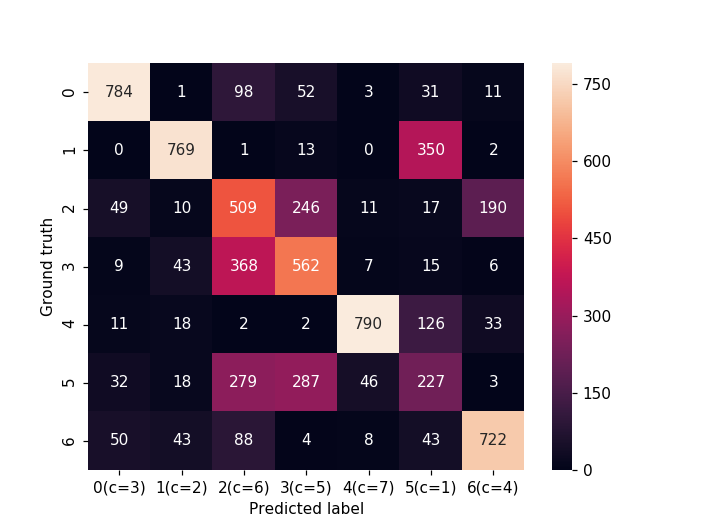

Text(50.722222222222214, 0.5, 'Ground truth')

In [137]:
plt.figure()
sns.heatmap(sklearn.metrics.confusion_matrix(ds.labels, assign_l),
            yticklabels=np.arange(7), xticklabels=[f'{i}(c={label2assignment[i]+1})'for i in np.arange(7)], annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Ground truth')

<IPython.core.display.Javascript object>


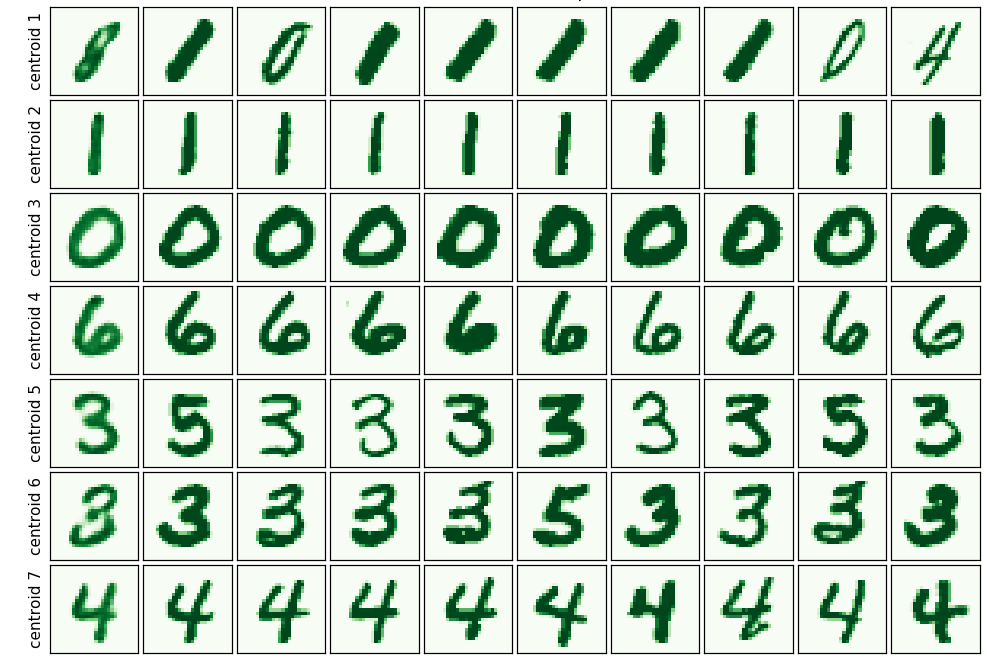

In [127]:
m = 9
fig, axs = plt.subplots(figsize=(9, 6), ncols=m+1, nrows=k)
for i in range(k):
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
#     im = dwe_smaller.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[i, 0].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[i, 0].get_xticklabels(), visible=False)
    plt.setp(axs[i, 0].get_yticklabels(), visible=False)
    axs[i, 0].tick_params(axis='both', which='both', length=0)
    axs[i, 0].set_ylabel(f'centroid {i+1}')
    chosen = np.argsort(dists[:, i])[:m]
    for j in range(1, m+1):
        axs[i, j].imshow(ds[chosen[j-1]][0].numpy(), cmap='Greens', interpolation='nearest')
        plt.setp(axs[i, j].get_xticklabels(), visible=False)
        plt.setp(axs[i, j].get_yticklabels(), visible=False)
        axs[i, j].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_title('Centroids')
axs[0, 1 + m//2].set_title(f'{m} closest points')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99, top=0.99, bottom=0.01)

## All

In [56]:
k=10
ds = DigitDataset(test_ds, set(list(range(10))))
%time algo.fit(ds, k=k, has_y=False, max_iter=10000, lr=0.3, ntries=20)


Wall time: 22.9 s


In [57]:
algo._compute_likelihood()

2.6158006

In [58]:
pd.value_counts(algo.assignment)

0    1536
4    1259
2    1254
6    1062
5     961
9     947
3     806
1     786
8     751
7     638
dtype: int64

<IPython.core.display.Javascript object>


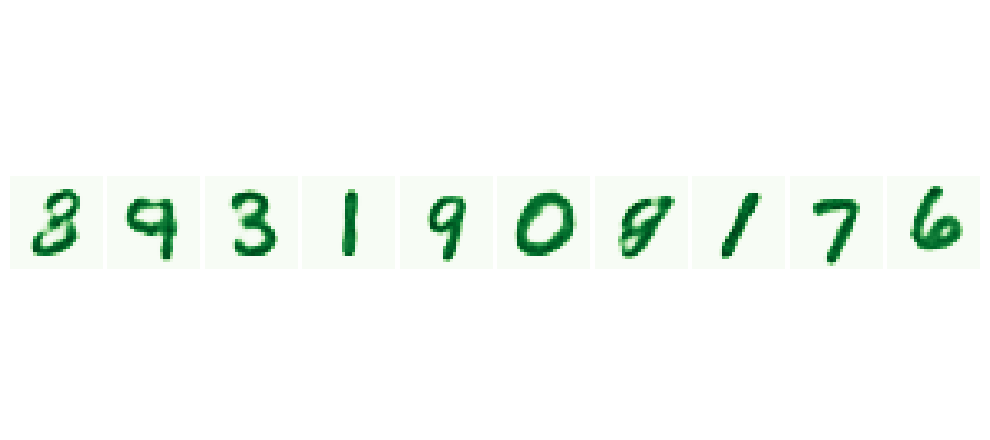

In [59]:
fig, axs = plt.subplots(figsize=(9, 4), ncols=k)
for i in range(k):
    im = decode_latent(dwe.decoder, algo.centroids[i])[0]
    axs[i].imshow(im, cmap='Greens', interpolation='nearest')
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.01, right=0.99)

In [68]:
M = np.zeros((10, 10))
for i in range(10):
    id_i = (algo.assignment == i)
    vc = pd.value_counts(ds.labels[id_i])
    for j in range(10):
        if not j in vc.index:
            M[i, j] = 0
        else:
            M[i, j] = vc.loc[j]

In [78]:
a = b = np.ones(10) / 10
ot.emd(a, b, -M).argmax(1)

array([2, 4, 3, 1, 9, 0, 5, 8, 7, 6], dtype=int64)

In [79]:
assignment2label = dict(zip(np.arange(10), ot.emd(a, b, -M).argmax(1)))
label2assignment = {v: k for k, v in assignment2label.items()}
assign_l = np.array([assignment2label[x] for x in algo.assignment])
acc = (assign_l == ds.labels).mean()
print(f'Mean accuracy : {acc:.3f}')

Mean accuracy : 0.501


In [80]:
(ds.labels == 1).sum(), 647 + 2 + 8 + 1 + 2 + 474 + 1

(1135, 1135)

<IPython.core.display.Javascript object>


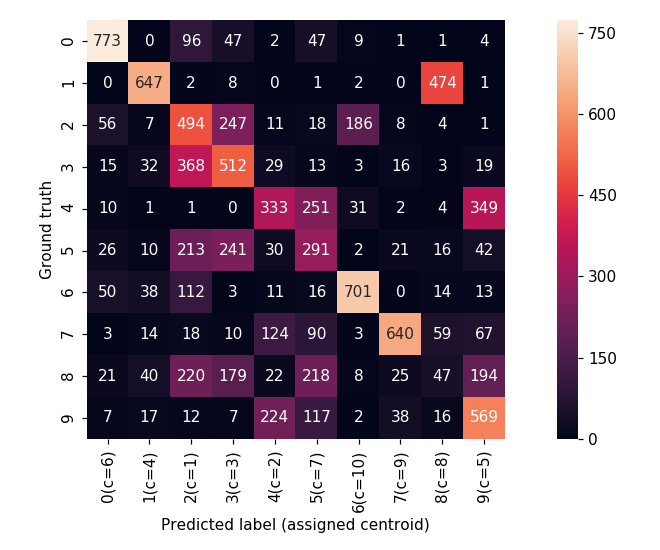

In [84]:
plt.figure(figsize=(6, 5))
sns.heatmap(sklearn.metrics.confusion_matrix(ds.labels, assign_l),
            yticklabels=np.arange(10), xticklabels=[f'{i}(c={label2assignment[i]+1})'for i in np.arange(10)],
            annot=True, fmt='d')
plt.xlabel('Predicted label (assigned centroid)')
plt.ylabel('Ground truth')
plt.tight_layout()
plt.axis('scaled')
plt.savefig('figures/wkm_confm')

<IPython.core.display.Javascript object>


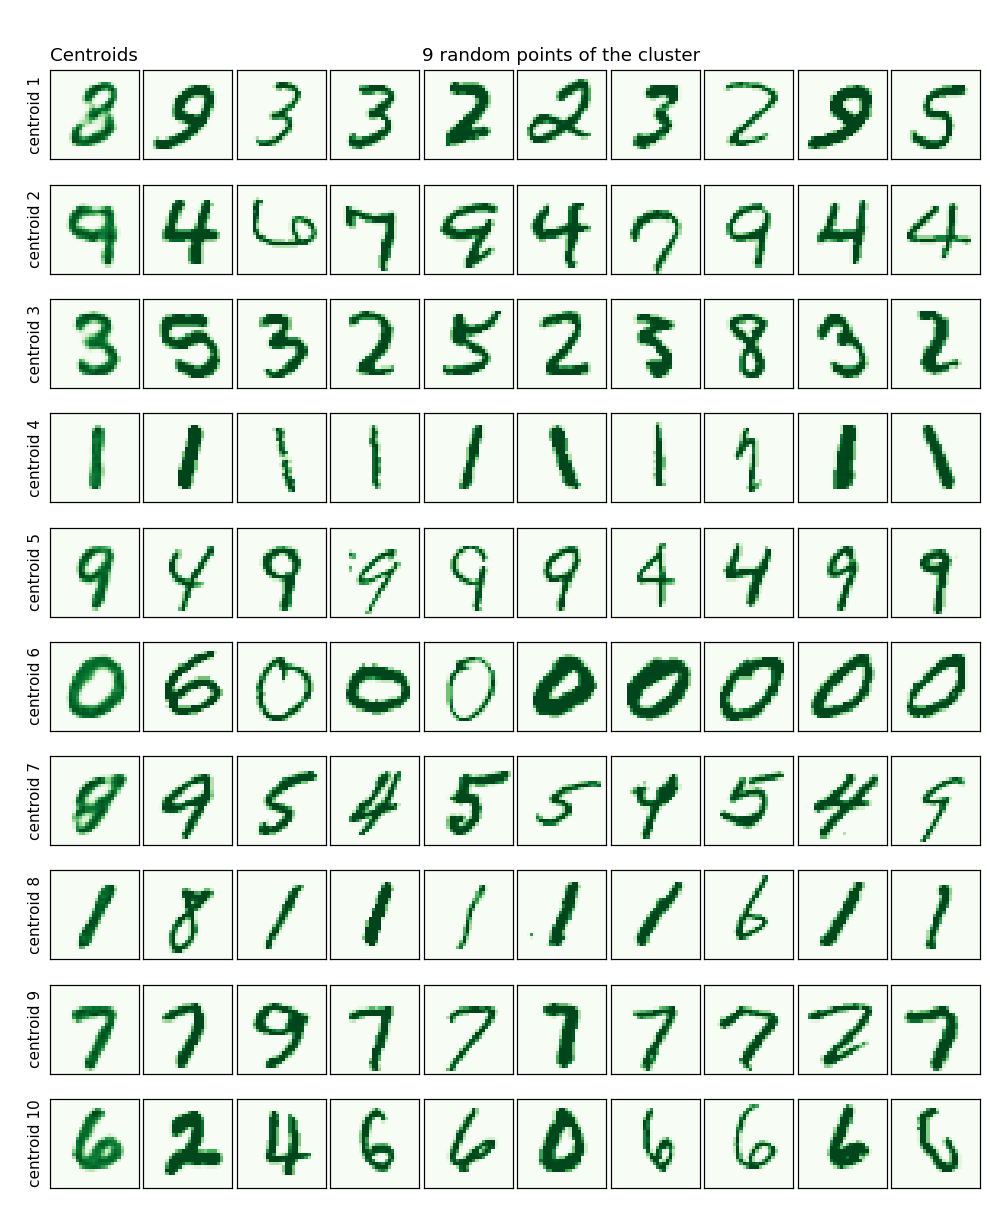

In [86]:
plot_clusters(ds, algo, dwe.decoder, m=9, random=True);
plt.savefig('figures/wkmeans_09_k10')

In [87]:
stacked_digit = []
for i in range(len(ds)):
    stacked_digit.append(ds[i].flatten())
stacked_digit = np.stack(stacked_digit)

In [88]:
sk_algo = sklearn.cluster.KMeans(n_clusters=10)

In [89]:
%time sk_algo.fit(stacked_digit)

Wall time: 14.1 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [91]:
14.1/10, 1.92

(1.41, 1.92)

<IPython.core.display.Javascript object>


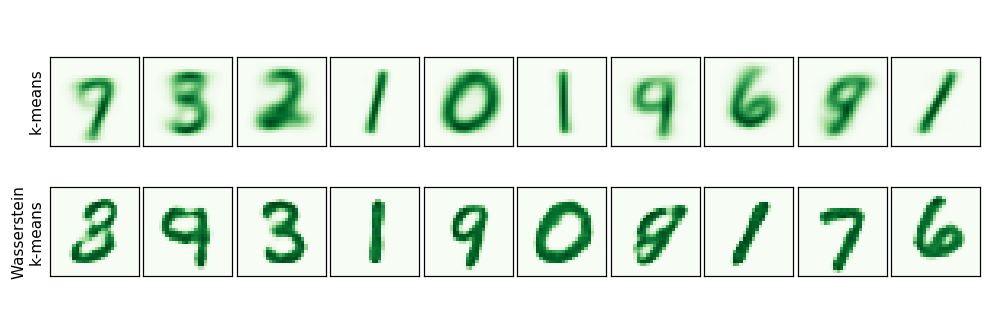

In [93]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=k, nrows=2)
for i in range(k):
    im = sk_algo.cluster_centers_[i].reshape(28, 28)
    axs[0, i].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[0, i].get_xticklabels(), visible=False)
    plt.setp(axs[0, i].get_yticklabels(), visible=False)
    axs[0, i].tick_params(axis='both', which='both', length=0)
    im = dwe.decoder(torch.tensor(algo.centroids[i]).float()[None]).detach().cpu().numpy()[0, 0]
    axs[1, i].imshow(im, cmap='Greens', interpolation='nearest')
    plt.setp(axs[1, i].get_xticklabels(), visible=False)
    plt.setp(axs[1, i].get_yticklabels(), visible=False)
    axs[1, i].tick_params(axis='both', which='both', length=0)
axs[0, 0].set_ylabel('k-means')
axs[1, 0].set_ylabel('Wasserstein\nk-means')
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.99)
plt.savefig('figures/wkm_km_c')

# Low-dim latent space (gaussian)

## Creating dataset

In [7]:
max_mu = -1
min_mu = 1
max_sigma = 3
min_sigma = 1

In [8]:
# ds, ys = generate_dataset(30000, limits=[min_mu, max_mu, min_sigma, max_sigma], sample_size=1000)
# np.save('data/gaussians', ds)
# ys.to_pickle('data/gaussian_labels')

In [9]:
ds = np.load('data/gaussians.npy')
ys = pd.read_pickle('data/gaussian_labels')

In [10]:
# train_ds = DWE_dsGaussian(ds, ys, N=300000)
# train_ds.save('data/train_Gauss.csv')
train_ds = DWE_dsGaussian(ds, ys, N=300000, from_file=pd.read_csv('data/train_Gauss.csv', index_col=0))

In [11]:
# val_ds = DWE_dsGaussian(ds, ys, N=50000)
# val_ds.save('data/val_Gauss.csv')
val_ds = DWE_dsGaussian(ds, ys, N=50000, from_file=pd.read_csv('data/val_Gauss.csv', index_col=0))

In [12]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False, **kwargs)

In [13]:
e = Encoder(input_dim=100, embed_dim=30, hidden_dims=[100, 50])
d = Decoder(embed_dim=30, output_dim=100, hidden_dims=[50, 100])

In [14]:
# dwe = DWE(e, d, 1, cuda=True, lr=1e-3)
dwe = DWE(e, d, 1, cuda=True, lr=1e-3, from_dir='models', name='gaussians')

## Training

In [52]:
dwe.train(train_loader, has_y=False, nepochs=5, valloader=val_loader)

Mean train loss : 0.77 (Wasserstein : 0.62 - data : 0.15)
Mean train accuracy : 0.35
Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.04


Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.03
Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.03


Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.02
Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.02


Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.02
Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.02


Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.01
Mean train loss : 0.00 (Wasserstein : 0.00 - data : 0.00)
Mean train accuracy : 0.02


In [53]:
i = 10
input = train_ds[i][0].numpy()
input_hat = dwe.decoder(dwe.encoder(train_ds[i][0][None].cuda())).detach().cpu().numpy()[0]

<IPython.core.display.Javascript object>


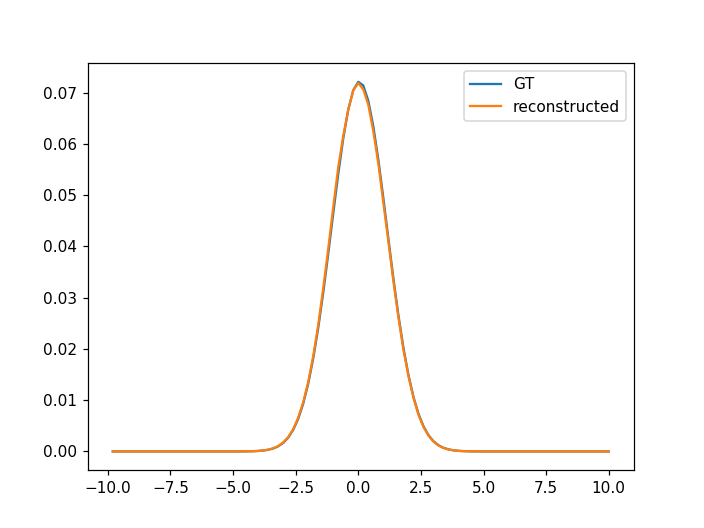

In [54]:
plt.figure()
plt.plot(np.linspace(-10, 10, 101)[1:], input, label='GT')
plt.plot(np.linspace(-10, 10, 101)[1:], input_hat, label='reconstructed')
plt.legend()

In [55]:
dwe.save('models', 'gaussians')

## Tests

### Inside training manifold (good)

In [69]:
dwe = DWE(e, d, 1, cuda=True, lr=1e-3, from_dir='models', name='gaussians')

In [98]:
ds2, ys2 = generate_dataset(10000, limits=[min_mu, max_mu, min_sigma, max_sigma], sample_size=1000)
np.save('data/gaussians_test', ds2)
ys2.to_pickle('data/gaussian_labels_test')

In [17]:
ds2 = np.load('data/gaussians_test.npy')
ys2 = pd.read_pickle('data/gaussian_labels_test')

In [18]:
# test_ds = DWE_dsGaussian(ds2, ys2, N=50000)
# test_ds.save('data/test_Gauss.csv')
test_ds = DWE_dsGaussian(ds2, ys2, N=50000, from_file=pd.read_csv('data/test_Gauss.csv', index_col=0))

In [28]:
preds = []
ys = []
len_test = len(test_ds)
data = np.zeros((len_test*2, 30))
with torch.no_grad():
    for i in tqdm.tqdm_notebook(range(len(test_ds))):
        x1, x2, y = test_ds[i]
        if use_cuda:
            x1 = x1.cuda()
            x2 = x2.cuda()
        phi1 = dwe.encoder(x1[None]).detach().cpu().numpy()
        phi2 = dwe.encoder(x2[None]).detach().cpu().numpy()
        data[2*i, :30] = phi1
        data[2*i+1, :30] = phi2
        pred = ((phi1 - phi2)**2).sum()
        preds.append(pred)
        ys.append(y)
preds = np.array(preds)
ys = np.array(ys)

In [29]:
errors = np.abs(ys - preds)
print(f'MAE = {(errors).mean():.3f}')
print(f'Relative MAE = {((errors)/(ys + 1e-9)).mean():.3f}')
print(f'MSE = {((ys - preds)**2).mean():.6f}')
print(f'Relative MSE = {(((ys - preds)**2)/(ys + 1e-9)).mean():.6f}')
print(f'Correlation = {np.corrcoef(np.stack((preds, ys)))[0, 1]:.6f}')
print(f'Error quantiles : 1% : {np.quantile(errors, 0.01):.6f}| 50% : {np.quantile(errors, 0.5):.6f}| 99% : {np.quantile(errors, 0.99):.6f}')
print(f'Mean distance : {ys.mean():.6f}')

MAE = 0.015
Relative MAE = 0.013
MSE = 0.000416
Relative MSE = 0.000227
Correlation = 0.999949
Error quantiles : 1% : 0.000085| 50% : 0.011197| 99% : 0.057962
Mean distance : 1.998367


In [68]:
0.059224/2.016786, 0.011256/2.016786

(0.029365535064206114, 0.005581157346391734)

<IPython.core.display.Javascript object>


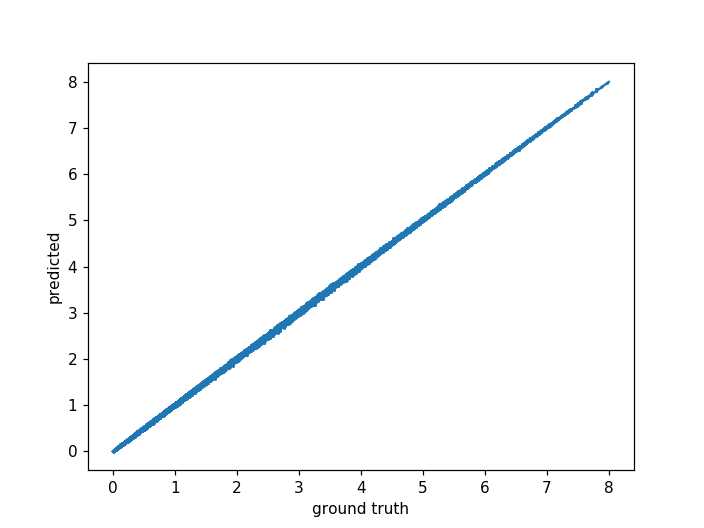

In [30]:
plt.figure()
plt.scatter(ys, preds, s=1)
plt.xlabel('ground truth')
plt.ylabel('predicted')
plt.plot([0, 8], [0, 8])
plt.savefig('figures/corr_preds_gaussian')

### Outside training manifold (bad)

In [69]:
ds2, ys2 = generate_dataset(10000, limits=[min_mu*2, max_mu*2, min_sigma/3, max_sigma*3], sample_size=1000)
np.save('data/gaussians_test', ds2)
ys2.to_pickle('data/gaussian_labels_test')

In [70]:
ds2 = np.load('data/gaussians_test.npy')
ys2 = pd.read_pickle('data/gaussian_labels_test')

In [71]:
test_ds = DWE_dsGaussian(ds2, ys2, N=50000)
test_ds.save('data/test_Gauss.csv')
test_ds = DWE_dsGaussian(ds2, ys2, N=50000, from_file=pd.read_csv('data/test_Gauss.csv', index_col=0))

In [72]:
preds = []
ys = []
len_test = len(test_ds)
data = np.zeros((len_test*2, 30))
with torch.no_grad():
    for i in tqdm.tqdm_notebook(range(len(test_ds))):
        x1, x2, y = test_ds[i]
        if use_cuda:
            x1 = x1.cuda()
            x2 = x2.cuda()
        phi1 = dwe.encoder(x1[None]).detach().cpu().numpy()
        phi2 = dwe.encoder(x2[None]).detach().cpu().numpy()
        data[2*i, :30] = phi1
        data[2*i+1, :30] = phi2
        pred = ((phi1 - phi2)**2).sum()
        preds.append(pred)
        ys.append(y)
preds = np.array(preds)
ys = np.array(ys)

In [73]:
errors = np.abs(ys - preds)
print(f'MAE = {(errors).mean():.3f}')
print(f'Relative MAE = {((errors)/(ys + 1e-9)).mean():.3f}')
print(f'MSE = {((ys - preds)**2).mean():.6f}')
print(f'Relative MSE = {(((ys - preds)**2)/(ys + 1e-9)).mean():.6f}')
print(f'Correlation = {np.corrcoef(np.stack((preds, ys)))[0, 1]:.6f}')
print(f'Error quantiles : 1% : {np.quantile(errors, 0.01):.6f}| 50% : {np.quantile(errors, 0.5):.6f}| 99% : {np.quantile(errors, 0.99):.6f}')
print(f'Mean distance : {ys.mean():.6f}')

MAE = 18.139
Relative MAE = 0.750
MSE = 670.268946
Relative MSE = 15.268156
Correlation = 0.686715
Error quantiles : 1% : 0.015615| 50% : 11.222953| 99% : 65.731793
Mean distance : 22.563250


<IPython.core.display.Javascript object>


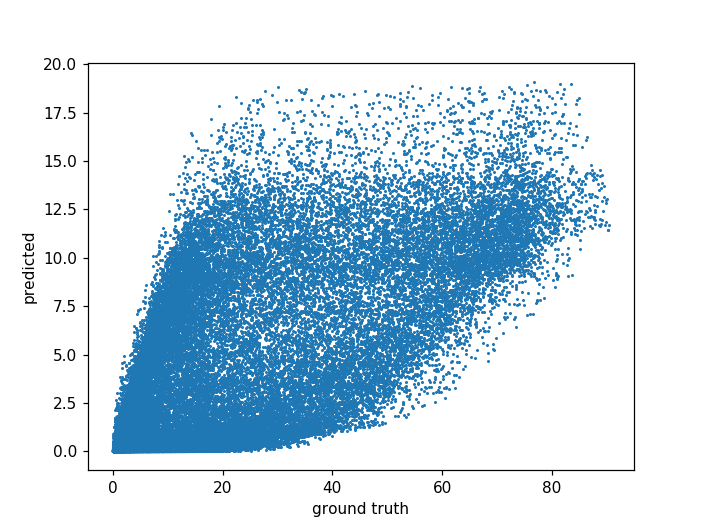

In [74]:
plt.figure()
plt.scatter(ys, preds, s=1)
plt.xlabel('ground truth')
plt.ylabel('predicted')
plt.plot([0, 8], [0, 8])
# plt.savefig('figures/corr_preds_gaussian')

## Transport plans

In [19]:
id1, id2 = test_ds.id_to_pair[0]

In [20]:
_, mu1, sigma1 = ys2.loc[id1]
_, mu2, sigma2 = ys2.loc[id2]

In [21]:
x1, x2, _ = test_ds[0]

In [22]:
l12 = dwe.encoder(torch.stack((x1, x2)).cuda())

In [23]:
ts = np.linspace(0, 1, 50)
interpol = []
for t in ts:
    interpol.append(t * l12[0] + (1-t) * l12[1])
interpol = torch.stack(interpol)

In [24]:
decoded = dwe.decoder(interpol).detach().cpu().numpy()

In [25]:
bins = np.linspace(-10, 10, 100)

In [26]:
def get_mean_std(x):
    samples = np.random.choice(bins, size=1000000, p=x)
    return samples.mean(), samples.std() 

In [27]:
means, stds = np.zeros(len(decoded)), np.zeros(len(decoded))
for i in tqdm.tqdm_notebook(range(len(decoded))):
    m, s = get_mean_std(decoded[i])
    means[i] = m
    stds[i] = s

<IPython.core.display.Javascript object>


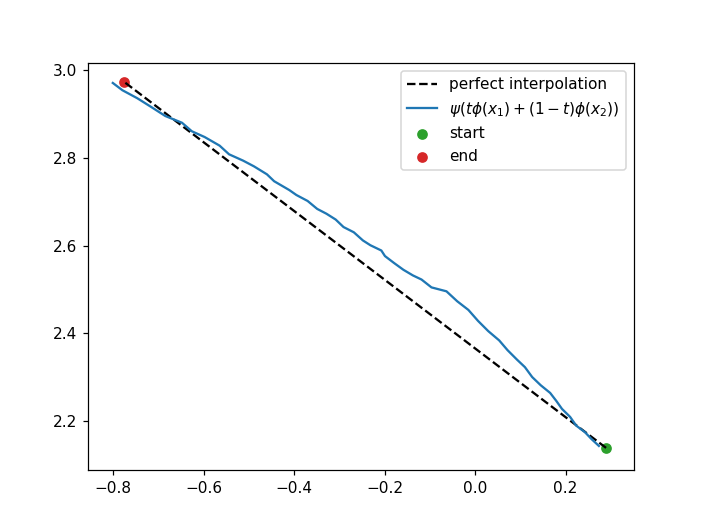

In [176]:
plt.figure()
plt.scatter([mu1], [sigma1], color='tab:green', label='start')
plt.scatter([mu2], [sigma2], color='tab:red', label='end')
plt.plot([mu1, mu2], [sigma1, sigma2], linestyle='--', color='black', label='perfect interpolation')
plt.plot(means, stds, label=r'$\psi(t\phi(x_1) + (1-t)\phi(x_2))$')
plt.legend()

In [177]:
id1, _ = test_ds.id_to_pair[0]
_, mu1, sigma1 = ys2.loc[id1]
x1, _, _ = test_ds[0]

In [178]:
ts = np.linspace(0, 1, 50)
bins = np.linspace(-10, 10, 100)

<IPython.core.display.Javascript object>


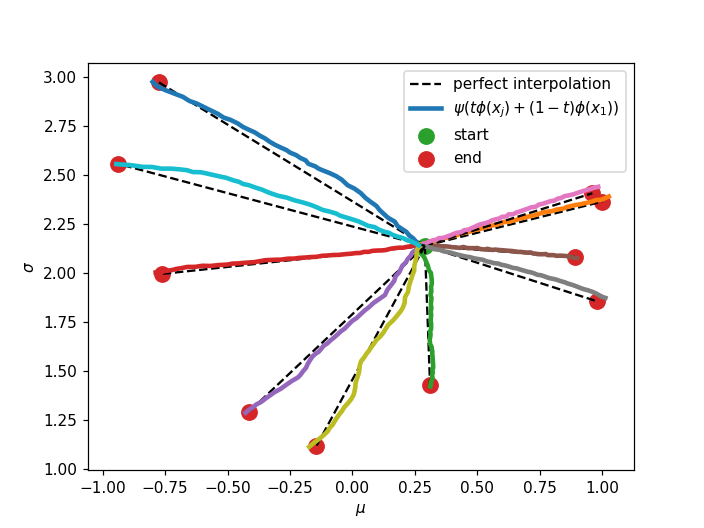

In [179]:
plt.figure()
plt.scatter([mu1], [sigma1], color='tab:green', label='start', s=100)
for j in tqdm.tqdm_notebook(range(10)):
    _, idj = test_ds.id_to_pair[j]
    _, muj, sigmaj = ys2.loc[idj]
    _, xj, _ = test_ds[j]
    l12 = dwe.encoder(torch.stack((x1, xj)).cuda())
    interpol = []
    for t in ts:
        interpol.append(t * l12[0] + (1-t) * l12[1])
    interpol = torch.stack(interpol)
    decoded = dwe.decoder(interpol).detach().cpu().numpy()
    means, stds = np.zeros(len(decoded)), np.zeros(len(decoded))
    for i in tqdm.tqdm_notebook(range(len(decoded))):
        m, s = get_mean_std(decoded[i])
        means[i] = m
        stds[i] = s
    if j == 0:
        plt.scatter([muj], [sigmaj], color='tab:red', label='end', s=100)
        plt.plot([mu1, muj], [sigma1, sigmaj], linestyle='--', color='black', label='perfect interpolation')
        plt.plot(means, stds, label=r'$\psi(t\phi(x_j) + (1-t)\phi(x_1))$', linewidth=3)
        
    else:
        plt.scatter([muj], [sigmaj], color='tab:red', s=100)
        plt.plot([mu1, muj], [sigma1, sigmaj], linestyle='--', color='black')
        plt.plot(means, stds, linewidth=3)
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.savefig('figures/gaussian_interp')